<a href="https://colab.research.google.com/github/dev-newsoft/FinalProject/blob/main/mypro2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 44.2 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0


In [2]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
import torch as th

from numpy import random
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

class Env(gym.Env):

  w_RSU=[50,-20,0]

  velocity=15  # m/s
  T = 40 # s eche period
  N = 40 # number of period
  tt=T/N
  movement=tt*velocity
  f_u_max = 20e9 # GHz

  f_k=0.7 * 10 ** 9
  f_u_k=1 * 10 ** 9 # GHz
  f_rc_k=2.8 * 10 ** 9 # GHz
  B0=10 ** -3 #-30 dB
  B=2*10 ** 6 #MHz
  p_k=0.5 #w
  a_k=0.5
  # a_u=0.8
  N0=10 **-16 #-130dBm/Hz
  t_k=1 #s
  p_u=0.8 #w


  #rsu config
  P_0=39.03 #w
  P_i=89.07 #w
  U_t= 100.0 #m/s
  v_0= 3.6 #m/s
  A=0.5030 #m2
  a_max = 5 #m/s2 acceleration
  v_max=20 # m/s speed
  v_last=5 # m/s speed
  a_rand=0
  v_rand=0
  d_0=0.4
  ss=0.1
  pp= 1.204 #kg/m3

  w_k=12
  Energy_Consumption=0
  process_time=0

  rewards=[]
  location=[]
  locat_u=[]
  loc_q1=[] # uav first location
  loc_q2=[] # uav first location  loc_w=[]
  w_D=[]
  w_C=[]

  observation_space = spaces.Box(low=np.array([[0,-250,100],[0,-250,100]]), high=np.array([[500,250,100],[500,250,100]]))

  action_space = spaces.MultiDiscrete([ 4, 4 ])


  def __init__(self):

      # self.start_state =np.append(self.loc_w,self.loc_q )
      # self.state = self.start_state
    self.rewards=[]
    self.location=[]
    self.locat_u=[]
    self.loc_q1=[100,-200,100] # uav first location
    self.loc_q2=[100,-200,100] # uav first location
    self.loc_w=[]
    self.w_D=[]
    self.w_C=[]

  #[w= Vehicle Location,q= UAV Location,D= input size ,C= cycles to process]
    for i in range(self.w_k):
      col = []
      if(i<6):
        col.append(random.randint(200,300))
        col.append(0)
        col.append(0)
      else:
        col.append(random.randint(400,500))
        col.append(0)
        col.append(0)

      self.loc_w.append(col)
      #input size
      self.w_D.append(random.randint(200000,2000000))
      #cycles to process
      self.w_C.append(random.randint(500,1500))

      self.state =np.array([self.loc_q1,self.loc_q2])

  def _get_obs(self):
      return np.array([self.loc_q1,self.loc_q2])

  def _get_history(self):
      _state=[]
      _state =np.append(self.loc_w,self.loc_q1 )
      _state = np.append(_state, self.loc_q2)
      _state = np.append(_state, self.w_D)
      _state = np.append(_state, self.w_C)
      return _state

  def reset(self,seed=None):
      self.reset_env()
      return self._get_obs(),{}

  def info(self):
      return {}

  def reset_env(self):
      # self.w_D = []
      # self.w_C = []
      # self.loc_w = []
      self.loc_q1=[100,-200,100] # uav first location
      self.loc_q2=[100,-200,100] # uav first location

      # for i in range(self.w_k):
      #   col = []
      #   if(i<6):
      #     col.append(random.randint(200,300))
      #     col.append(0)
      #     col.append(0)
      #   else:
      #     col.append(random.randint(400,500))
      #     col.append(0)
      #     col.append(0)

      #   self.loc_w.append(col)
      #   self.w_D.append(random.randint(200000,2000000))
      #   #cycles to process
      #   self.w_C.append(random.randint(500,1500))

  def update_env(self,action):

      dis_fly =15

      if(action[0]==0):
         self.loc_q1[0] = int((self.loc_q1[0] + dis_fly ))
      if(action[0]==1):
         self.loc_q1[0] = int((self.loc_q1[0] - dis_fly ))
      if(action[0]==2):
        self.loc_q1[1] =int((self.loc_q1[1] + dis_fly ))
      if(action[0]==3):
        self.loc_q1[1] =int((self.loc_q1[1] - dis_fly ))


# =================================================

      if(action[1]==0):
         self.loc_q2[0] = int((self.loc_q2[0] + dis_fly ))
      if(action[1]==1):
         self.loc_q2[0] = int((self.loc_q2[0] - dis_fly ))
      if(action[1]==2):
        self.loc_q2[1] =int((self.loc_q2[1] + dis_fly ))
      if(action[1]==3):
        self.loc_q2[1] =int((self.loc_q2[1] - dis_fly ))


      # loc_w_=self.loc_w
      # self.loc_w = []

      # for last in loc_w_:
      #   #Vehicle Location
      #   col = []
      #   for locat in last:
      #     if(locat!=0):
      #       t1=locat+random.randint(1,self.movement/5)  # movement
      #       if(t1>1000):
      #         col.append(1000) #(t1-1000)
      #       else:
      #         if(t1==0):
      #           t1=1
      #         col.append(t1)
      #     else:
      #       col.append(0)


      #   self.loc_w.append(col)


  def calculate_Energy(self):

      v=5#self.v_rand

      # print("\n---------------\n")
      E_f=0.5 * self.d_0 * self.pp * self.A * self.ss * (v ** 3)+self.P_0 * (1+ 3 * v**3 /self.U_t**2)+self.P_i * (((1+v**4/4*self.v_0**4)**0.5)-(v**2/2*self.v_0**2))
      # print("Energy_uav_movment:", E_f)
      Energy_Consumption=E_f*2
      p_k=0
      reset=False
      process_time=0

      for i in range(self.w_k):

        # print("\n---------------\n")
        my_loc_q=self.loc_q1
        if(np.linalg.norm(np.array(self.loc_w[i]) - np.array(self.loc_q1)) > np.linalg.norm(np.array(self.loc_w[i]) - np.array(self.loc_q2))):
          my_loc_q=self.loc_q2

        h = self.B0/(math.pow((np.linalg.norm(np.array(self.loc_w[i]) - np.array(my_loc_q))),2))

        R=(self.B/self.w_k)*math.log2(1+(self.w_k*((self.p_k*h)/(self.N0*self.B))))

        T_o_k=self.a_k*self.w_D[i]/R

        E_k=10 ** -26 * self.f_u_k ** 2 * min(self.f_u_k*(self.t_k-T_o_k) , self.a_k*self.w_D[i]*self.w_C[i])

        # print("Energy_uav_Computing", E_k)

        # in rsu
        E_rc_k=0

        D_r_k=self.a_k*self.w_D[i]-self.f_u_k*(self.t_k-T_o_k)/self.w_C[i] #remain tasks

        # print("D_r_k", D_r_k)

        t_r_k=0
        t_rc_k=0
        if(D_r_k <= 0):
          ggg=1
          # print("procesing finish in uav")
        else:
          # print("procesing start in rsu")

          h_r = self.B0/math.pow((np.linalg.norm(np.array(my_loc_q) - self.w_RSU)),2)
          R_k=(self.B/self.w_k)*math.log2(1+self.w_k*((self.p_u*h_r)/(self.B*self.N0)))
          t_r_k= D_r_k/R_k #relay time


          E_rc_k=1e-26 * self.f_rc_k ** 2 * min(self.f_rc_k*(self.t_k-t_r_k) ,(D_r_k*self.w_C[i]) )

          T_rc_k_e = self.a_k*self.w_D[i]*self.w_C[i]/self.f_rc_k
          delta_T_rc_k=(-self.a_k*self.w_D[i]*self.w_C[i]* -0.05*self.f_rc_k)/(self.f_rc_k*(self.f_rc_k+ -0.05*self.f_rc_k))
          t_rc_k=T_rc_k_e + delta_T_rc_k

          # print("Energy_rsu", E_rc_k)
        if(self.t_k<=t_r_k or self.t_k<=T_o_k):
          print("Time:",T_o_k, t_r_k)
          reset=True

        #time compute
        T_l_k_e = (1-self.a_k)*self.w_D[i]*self.w_C[i]/self.f_k
        delta_t_l_k=(-(1-self.a_k)*self.w_D[i]*self.w_C[i]* -0.05*self.f_k)/(self.f_k*(self.f_k+ -0.05*self.f_k))
        T_l_k=T_l_k_e + delta_t_l_k

        T_u_k_e = self.a_k*self.w_D[i]*self.w_C[i]/self.f_u_k
        delta_T_u_k=(-self.a_k*self.w_D[i]*self.w_C[i]* -0.05*self.f_u_k)/(self.f_u_k*(self.f_u_k+ -0.05*self.f_u_k))
        t_u_k=T_u_k_e + delta_T_u_k
        # print("t_u_k:", t_u_k)


        # print("t_u_k:", t_u_k)

        t_e_k=T_o_k+ max(t_r_k+t_rc_k,t_u_k)

        process_time=process_time+t_e_k

        # print(T_l_k,t_e_k)

        p_k= p_k + max(T_l_k-self.t_k,t_e_k-self.t_k,0)

        Energy_Consumption =Energy_Consumption+E_rc_k+E_k
      # print("\n---------------\n")

      p_k=100/self.w_k*p_k
      # print(p_k)

      reward=Energy_Consumption+p_k
      # print(Energy_Consumption,p_k)
      self.rewards.append(-reward)
      self.Energy_Consumption=Energy_Consumption
      self.process_time=process_time

      return -reward,reset


  def step(self,action):
      # print(action)
      self.update_env(action)

      reward,reset=self.calculate_Energy()

      next=self._get_obs()

      self.location.append(self._get_history())

      return next,reward, reset, False, {}



  def greedyDo(self):


      u_1=[]
      u_1.extend(self.loc_q1)
      u_2=[]
      u_2.extend(self.loc_q2)
      temp_Energy,temp_Time=self.calculate_Energy_greedy(u_1,u_2)
      win_loc_q1=u_1
      win_loc_q2=u_2
      win_Energy=temp_Energy
      win_Time=temp_Time

      for e in range(4):
        i=0
        if(e>1):
          i=1
        dis_fly =15
        if e % 2 == 1:
          dis_fly =-15
        u_1=[]
        u_1.extend(self.loc_q1)
        u_1[i] = int((self.loc_q1[i] + dis_fly ))
        for f in range(4):
          j=0
          if(f>1):
            j=1
          dis_fly2 =15
          if f % 2 == 1:
            dis_fly2 =-15
          u_2=[]
          u_2.extend(self.loc_q2)
          u_2[j] = int((self.loc_q2[j] + dis_fly2 ))
          temp_Energy,temp_Time=self.calculate_Energy_greedy(u_1,u_2)
          if(temp_Energy<win_Energy):
            win_loc_q1=u_1
            win_loc_q2=u_2
            win_Energy=temp_Energy
            win_Time=temp_Time

      self.loc_q1=win_loc_q1
      self.loc_q2=win_loc_q2
      self.location.append(self._get_history())

      # print(win_Energy)


      loc_w_=self.loc_w
      self.loc_w = []


      for last in loc_w_:
        #Vehicle Location
        col = []
        for locat in last:
          if(locat!=0):
            t1=locat+random.randint(1,self.movement/5)  # movement
            if(t1>1000):
              col.append(1000) #(t1-1000)
            else:
              if(t1==0):
                t1=1
              col.append(t1)
          else:
            col.append(0)


        self.loc_w.append(col)

      return win_Energy,win_Time

  def calculate_Energy_greedy(self,loc_q1,loc_q2):

      v=5#self.v_rand

      # print("\n---------------\n")
      E_f=0.5 * self.d_0 * self.pp * self.A * self.ss * (v ** 3)+self.P_0 * (1+ 3 * v**3 /self.U_t**2)+self.P_i * (((1+v**4/4*self.v_0**4)**0.5)-(v**2/2*self.v_0**2))
      # print("Energy_uav_movment:", E_f)
      Energy_Consumption=E_f*2
      p_k=0
      reset=False
      process_time=0

      for i in range(self.w_k):

        # print("\n---------------\n")

        my_loc_q=loc_q1
        if(np.linalg.norm(np.array(self.loc_w[i]) - np.array(loc_q1)) > np.linalg.norm(np.array(self.loc_w[i]) - np.array(loc_q2))):
          my_loc_q=loc_q2

        h = self.B0/(math.pow((np.linalg.norm(np.array(self.loc_w[i]) - np.array(my_loc_q))),2))

        R=(self.B/self.w_k)*math.log2(1+(self.w_k*((self.p_k*h)/(self.N0*self.B))))

        T_o_k=self.a_k*self.w_D[i]/R

        # print(self.f_u_k*(self.t_k-T_o_k) , self.a_k*self.w_D[i]*self.w_C[i])
        E_k=10 ** -26 * self.f_u_k ** 2 * min(self.f_u_k*(self.t_k-T_o_k) , self.a_k*self.w_D[i]*self.w_C[i])

        # in rsu
        E_rc_k=0

        D_r_k=self.a_k*self.w_D[i]-self.f_u_k*(self.t_k-T_o_k)/self.w_C[i] #remain tasks

        # print("D_r_k", D_r_k)

        t_r_k=0
        t_rc_k=0
        if(D_r_k <= 0):
          ggg=1
          # print("procesing finish in uav")
        else:
          # print("procesing start in rsu")

          h_r = self.B0/math.pow((np.linalg.norm(np.array(my_loc_q) - self.w_RSU)),2)
          R_k=(self.B/self.w_k)*math.log2(1+self.w_k*((self.p_u*h_r)/(self.B*self.N0)))
          t_r_k= D_r_k/R_k #relay time


          E_rc_k=1e-26 * self.f_rc_k ** 2 * min(self.f_rc_k*(self.t_k-t_r_k) ,(D_r_k*self.w_C[i]) )

          T_rc_k_e = self.a_k*self.w_D[i]*self.w_C[i]/self.f_rc_k
          delta_T_rc_k=(-self.a_k*self.w_D[i]*self.w_C[i] * -0.05*self.f_rc_k)/(self.f_rc_k*(self.f_rc_k+ -0.05*self.f_rc_k))
          t_rc_k=T_rc_k_e + delta_T_rc_k

          # print("Energy_rsu", E_rc_k)
        if(self.t_k<=t_r_k or self.t_k<=T_o_k):
          print("Time:",T_o_k, t_r_k)
        # print("Time:",T_o_k, t_r_k)

        #time compute
        T_l_k_e = (1-self.a_k)*self.w_D[i]*self.w_C[i]/self.f_k
        delta_t_l_k=(-(1-self.a_k)*self.w_D[i]*self.w_C[i]* -0.05*self.f_k)/(self.f_k*(self.f_k+ -0.05*self.f_k))
        T_l_k=T_l_k_e + delta_t_l_k

        T_u_k_e = self.a_k*self.w_D[i]*self.w_C[i]/self.f_u_k
        delta_T_u_k=(-self.a_k*self.w_D[i]*self.w_C[i]*-0.05*self.f_u_k)/(self.f_u_k*(self.f_u_k+ -0.05*self.f_u_k))
        t_u_k=T_u_k_e + delta_T_u_k
        # print("t_u_k:", t_u_k)


        # print("t_u_k:", t_u_k)

        t_e_k=T_o_k+ max(t_r_k+t_rc_k,t_u_k)

        process_time=process_time+t_e_k

        # print(T_l_k,t_e_k)

        p_k= p_k + max(T_l_k-self.t_k,t_e_k-self.t_k,0)

        Energy_Consumption =Energy_Consumption+E_rc_k+E_k
      # print("\n---------------\n")

      p_k=100/self.w_k*p_k
      # print(p_k)

      reward=Energy_Consumption+p_k

      return reward,process_time

  def randomDo(self):

      dis_fly =15
      action=random.randint(0,4)
      u_=[]
      u_.extend(self.loc_q1)
      if(action==0):
        u_[0] = int((self.loc_q1[0] + dis_fly ))

      if(action==1):
        u_[0] = int((self.loc_q1[0] - dis_fly ))

      if(action==2):
        u_[1] = int((self.loc_q1[1] + dis_fly ))

      if(action==3):
        u_[1] = int((self.loc_q1[1] - dis_fly ))

      action=random.randint(0,4)
      u_2=[]
      u_2.extend(self.loc_q2)
      if(action==0):
        u_2[0] = int((self.loc_q2[0] + dis_fly ))

      if(action==1):
        u_2[0] = int((self.loc_q2[0] - dis_fly ))

      if(action==2):
        u_2[1] = int((self.loc_q2[1] + dis_fly ))

      if(action==3):
        u_2[1] = int((self.loc_q2[1] - dis_fly ))

      temp_Energy,temp_Time=self.calculate_Energy_greedy(u_,u_2)
      # print(action)
      # if(u_[0]>1000):
      #   u_[0]=1000
      # if(u_[0]<0):
      #   u_[0]=0

      # if(u_[1]>500):
      #   u_[1]=500
      # if(u_[1]<-500):
      #   u_[1]=-500

      self.loc_q1=u_
      self.loc_q2=u_2
      self.location.append(self._get_history())
      print(temp_Energy)
      return temp_Energy,temp_Time

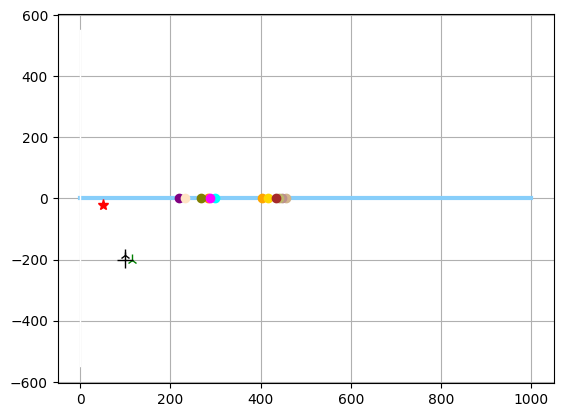

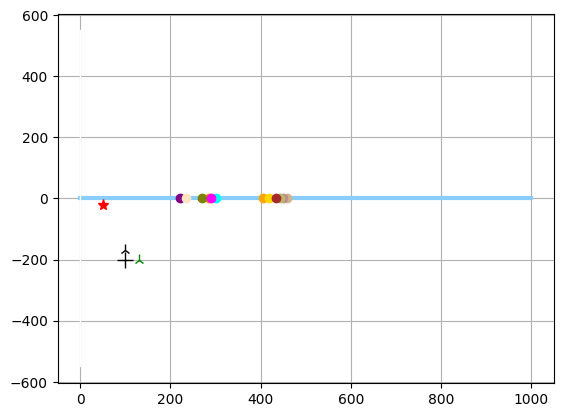

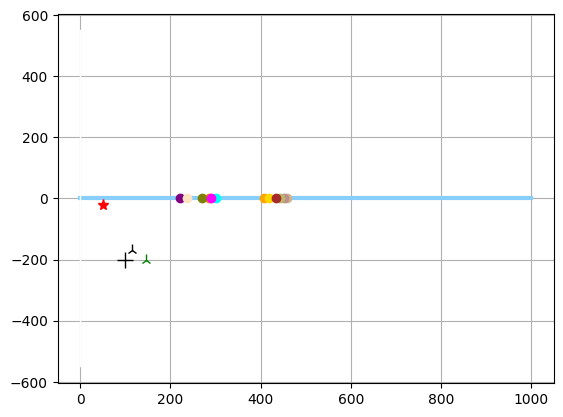

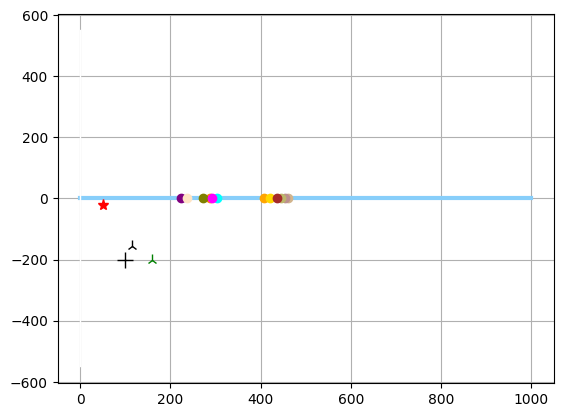

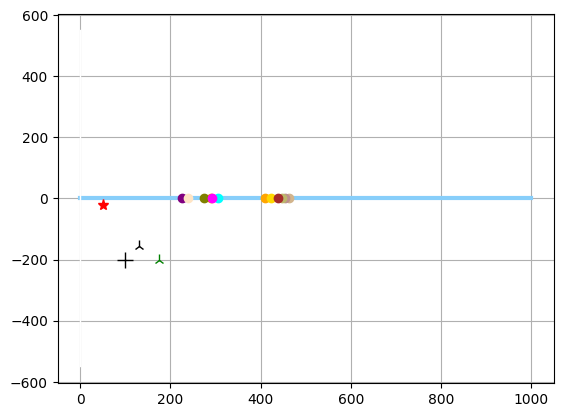

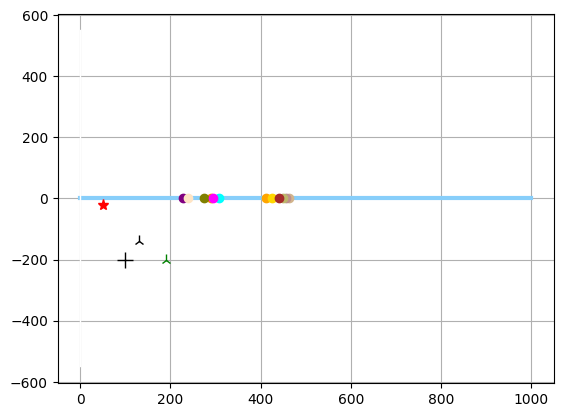

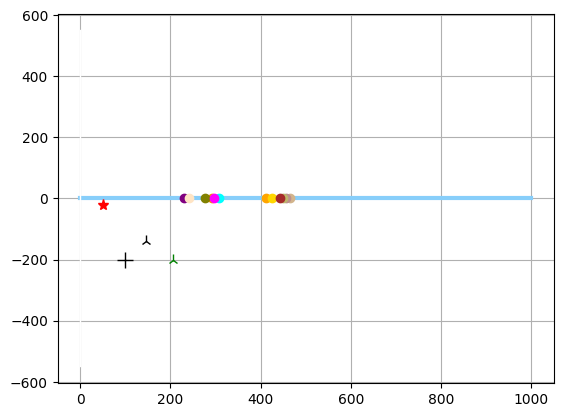

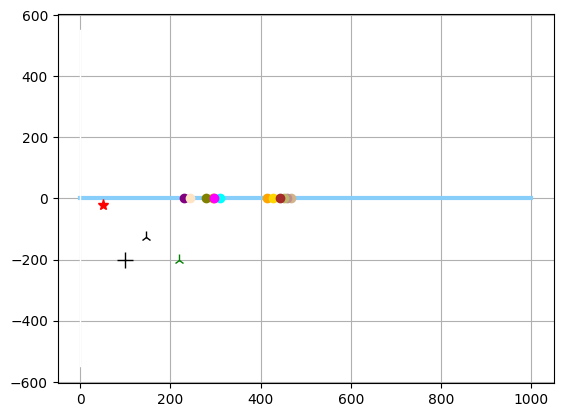

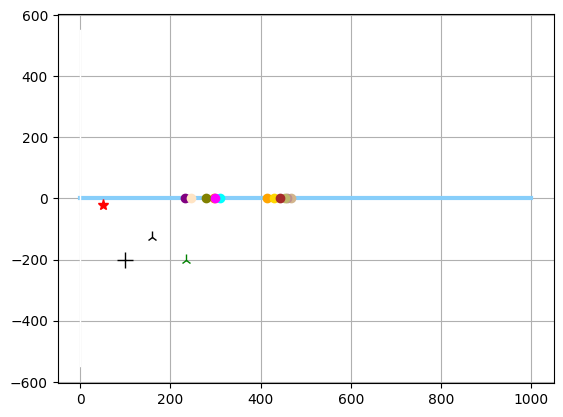

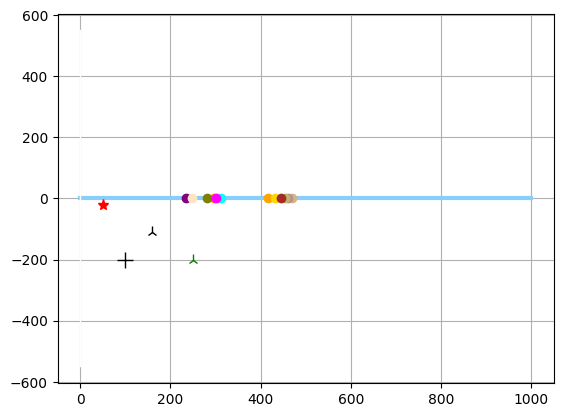

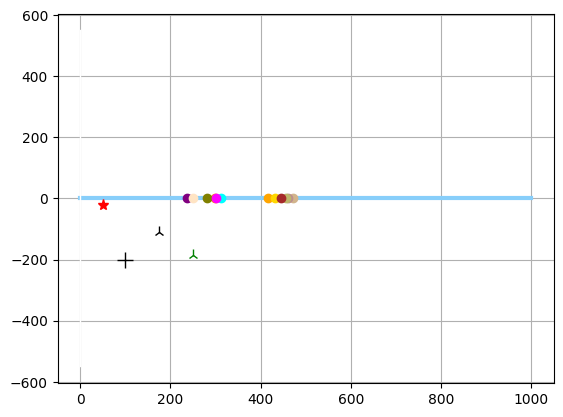

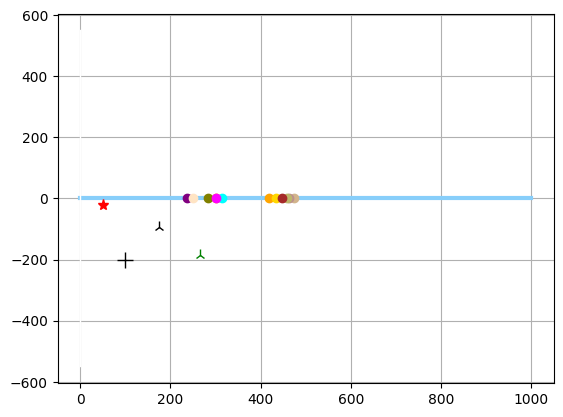

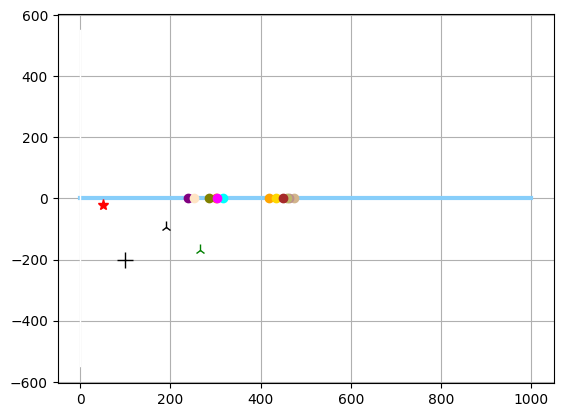

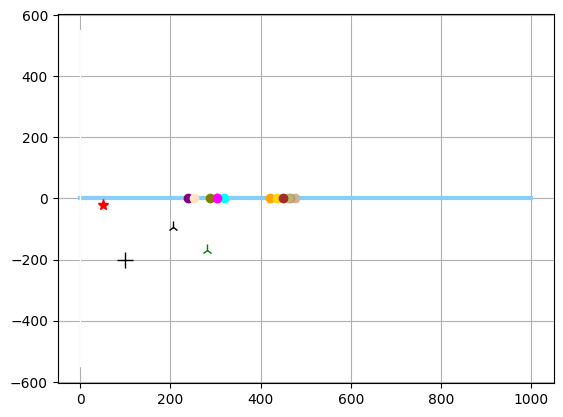

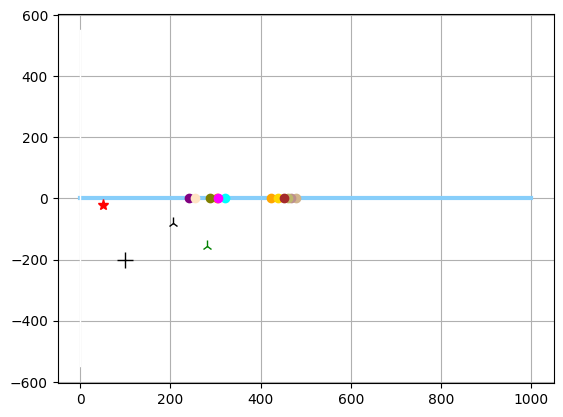

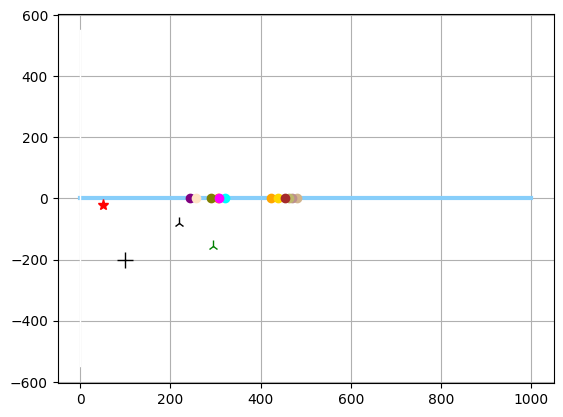

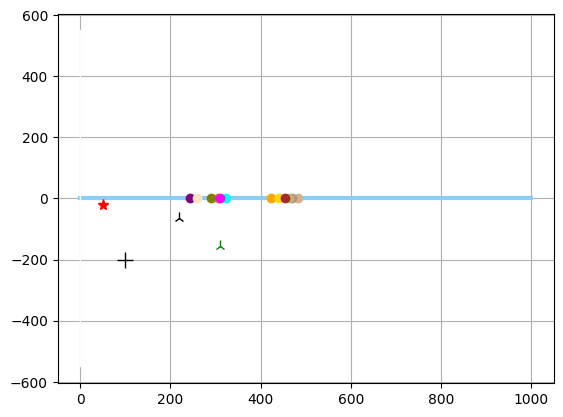

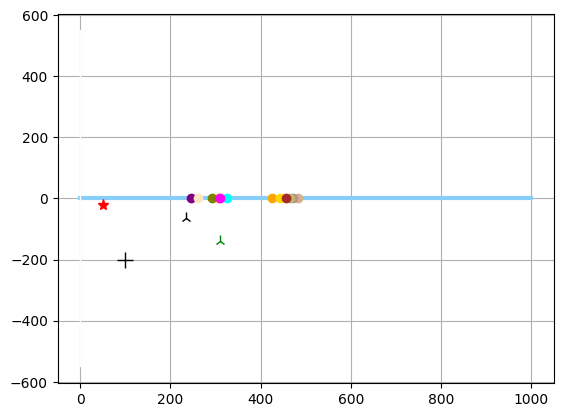

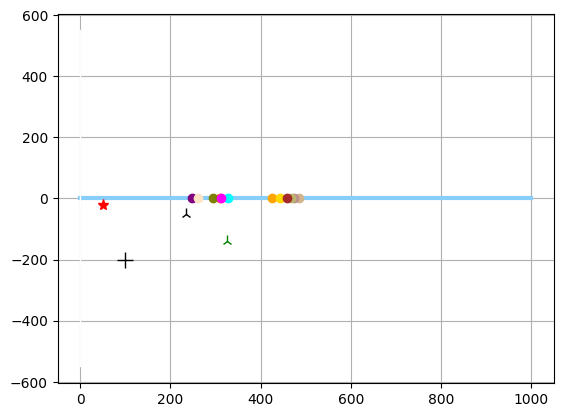

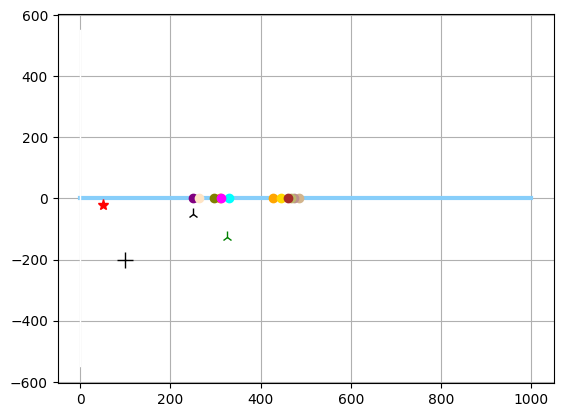

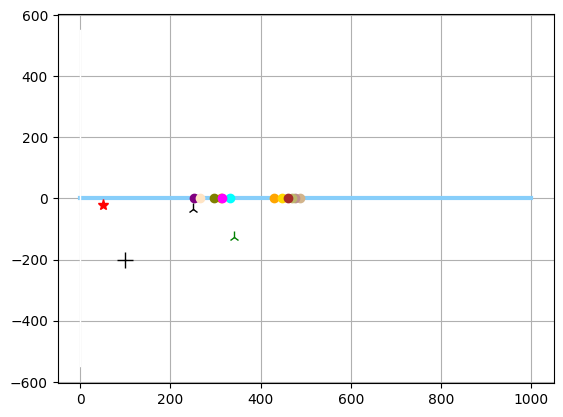

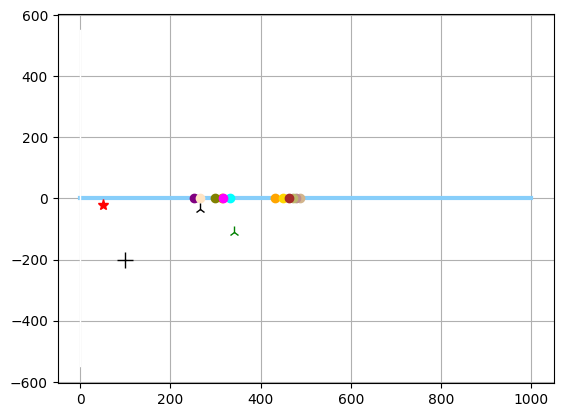

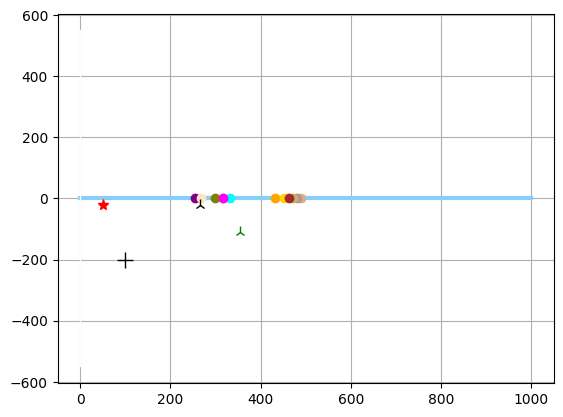

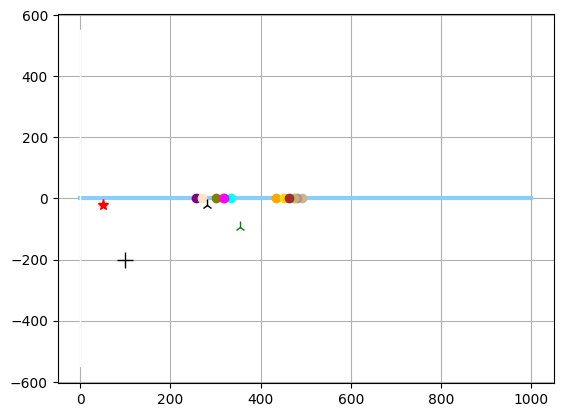

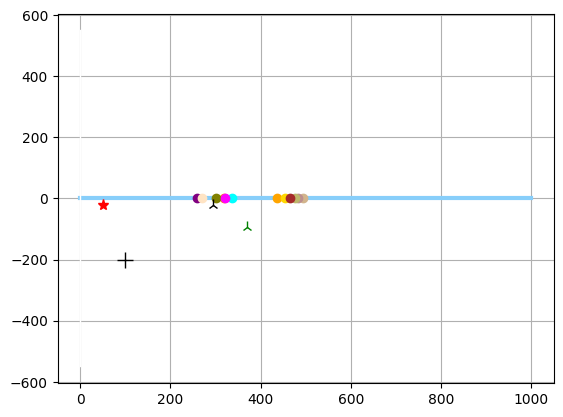

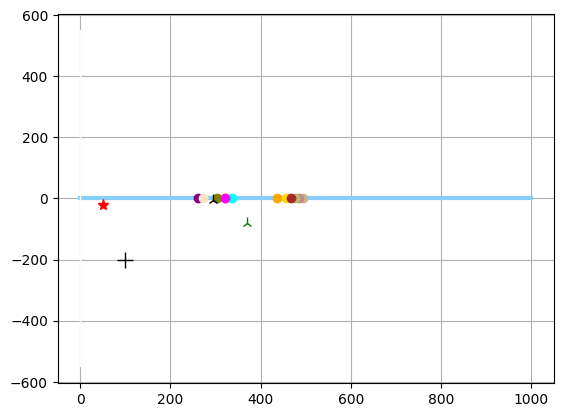

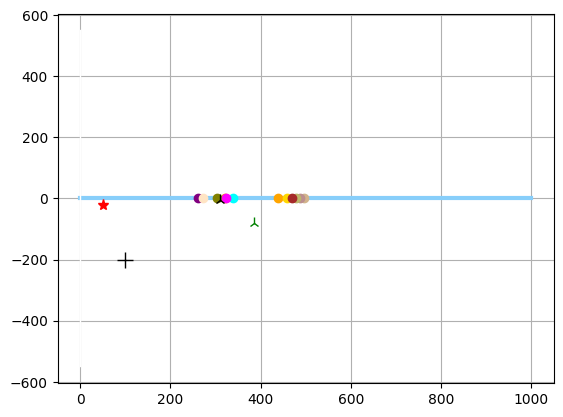

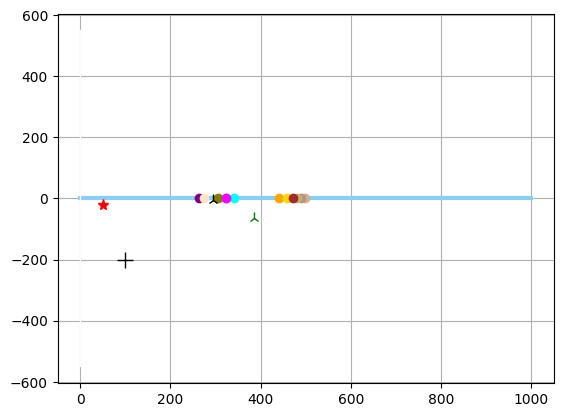

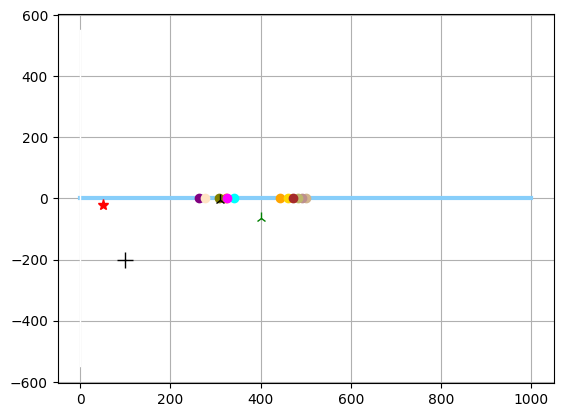

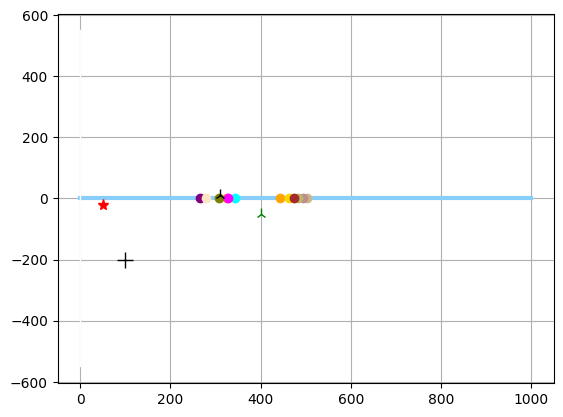

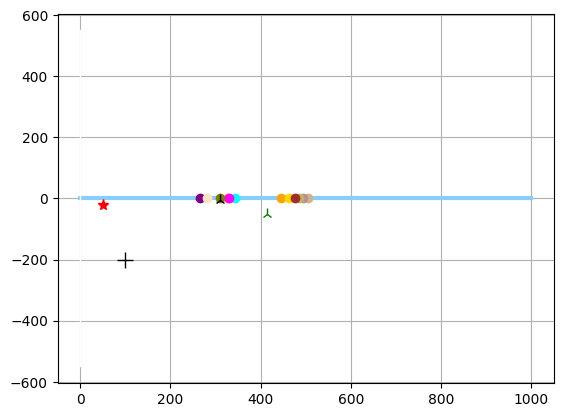

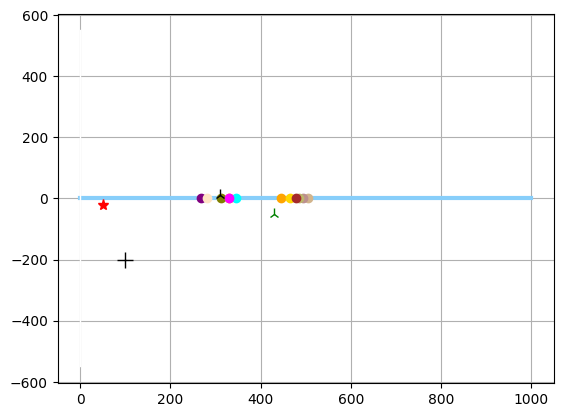

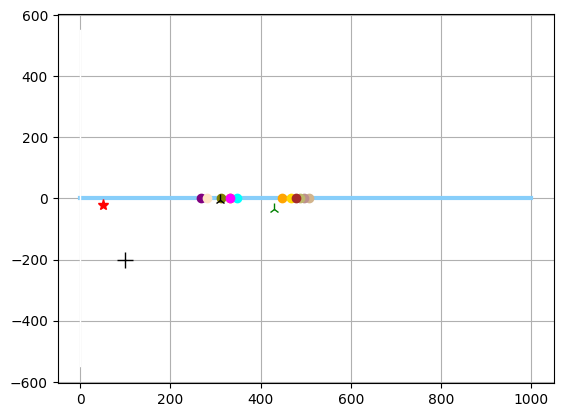

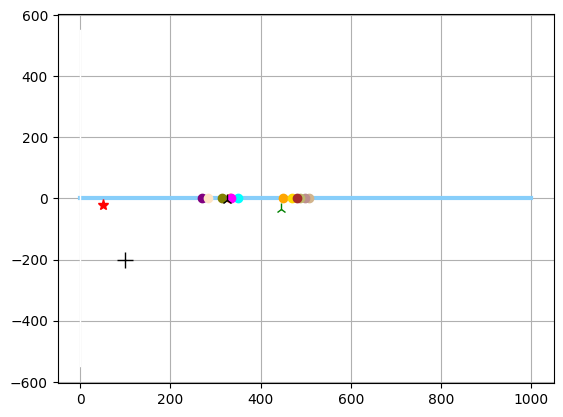

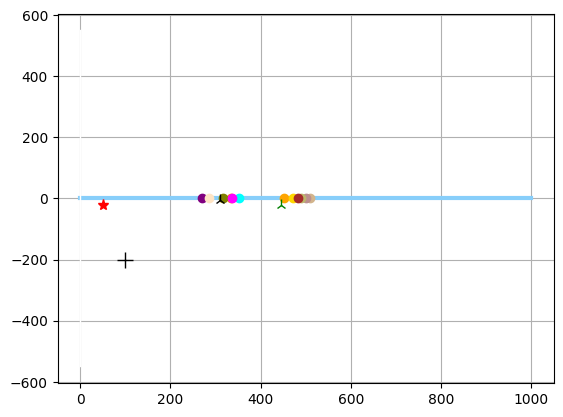

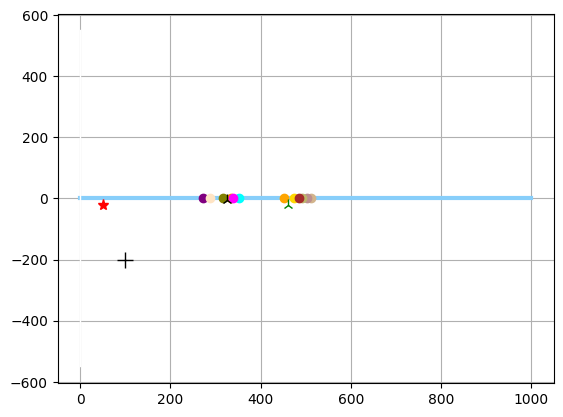

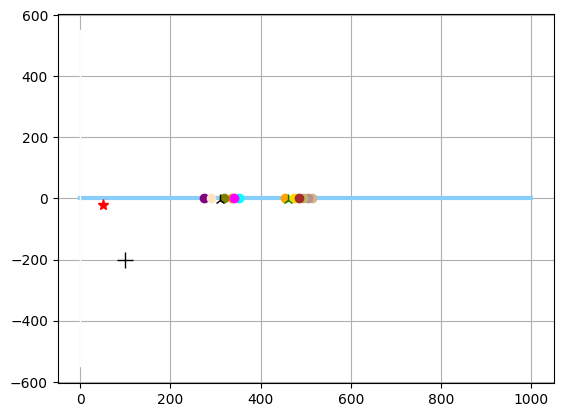

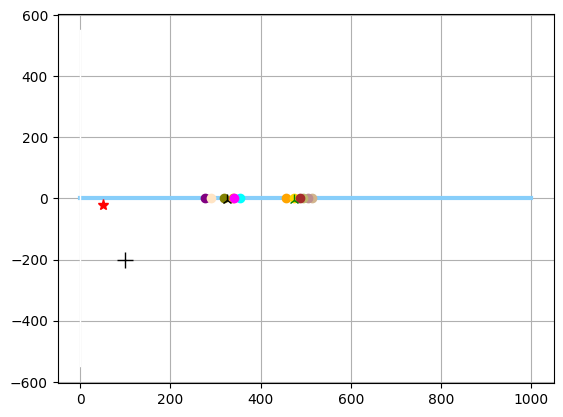

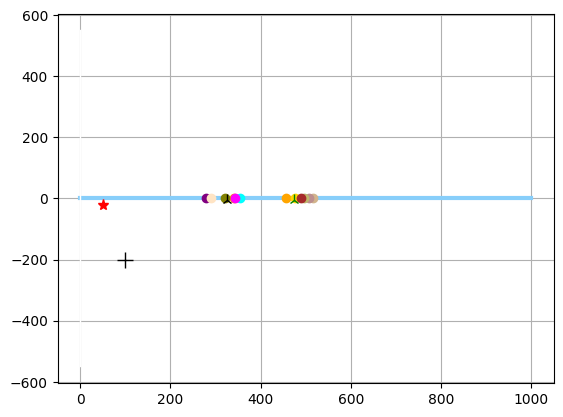

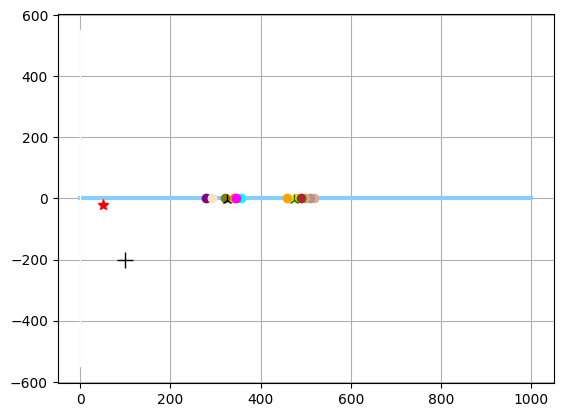

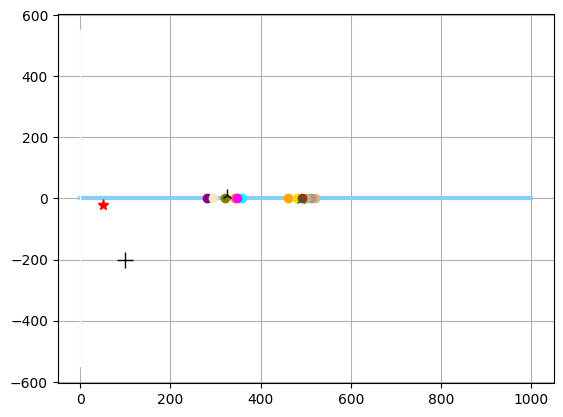

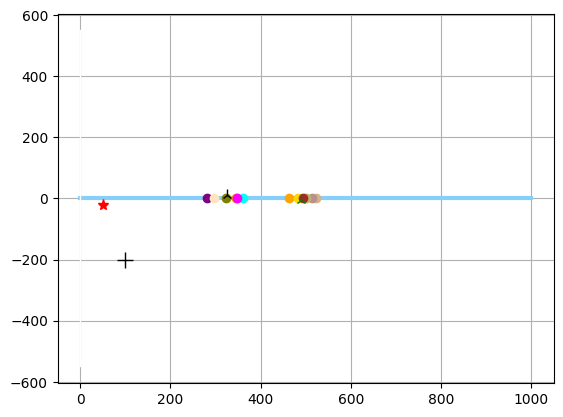

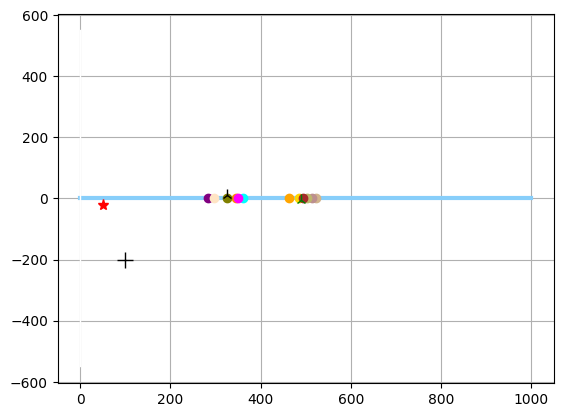

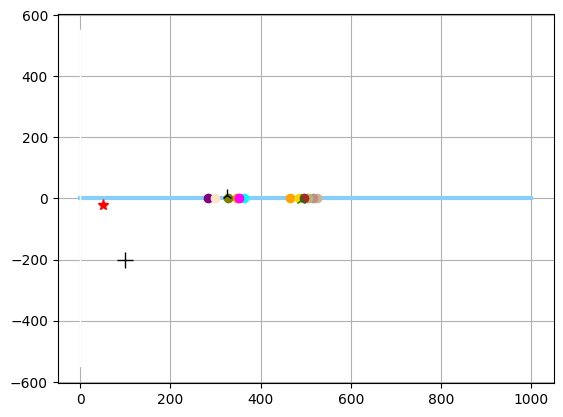

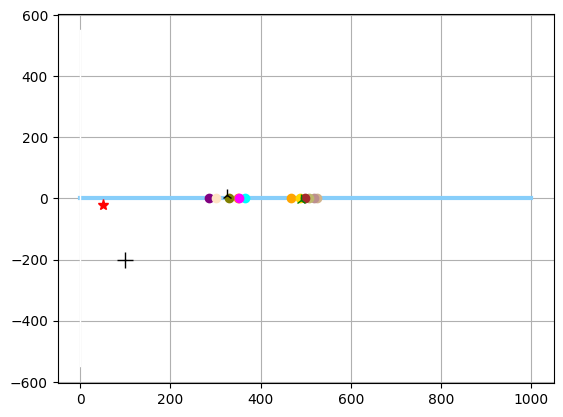

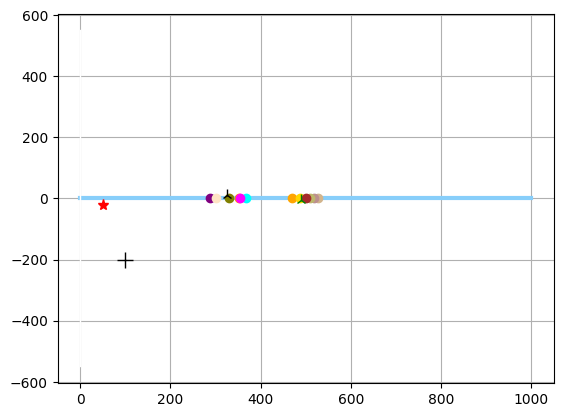

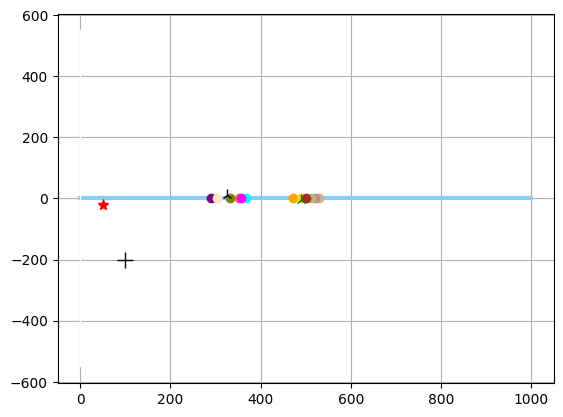

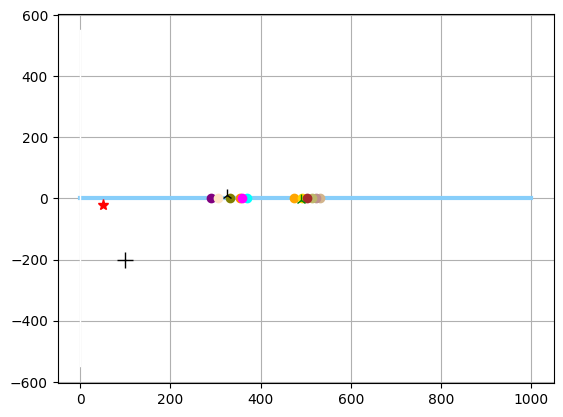

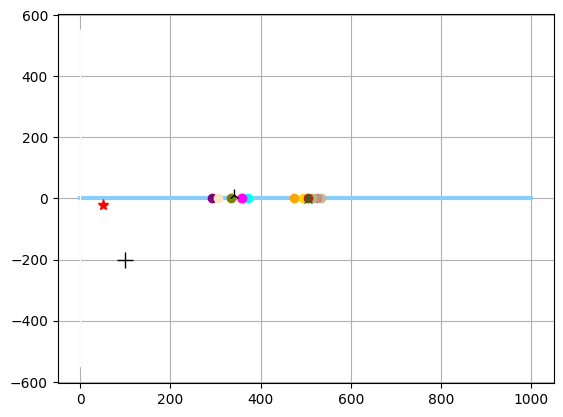

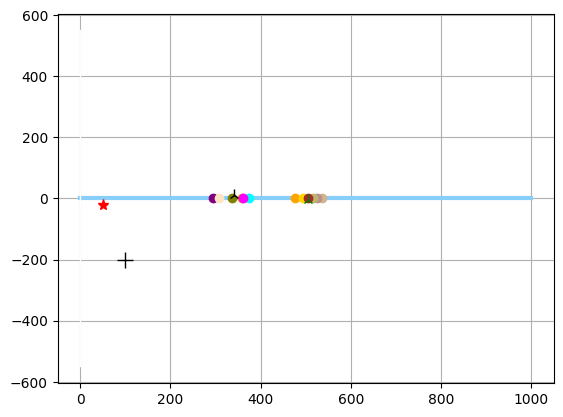

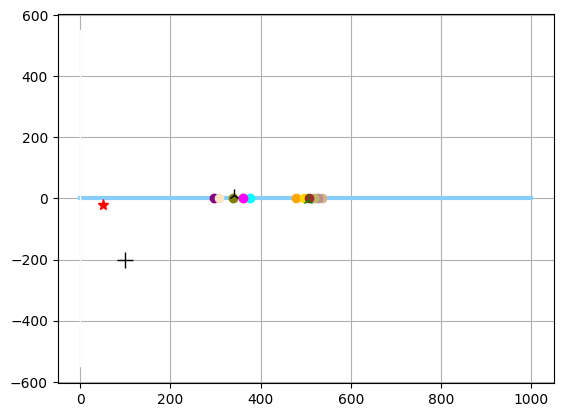

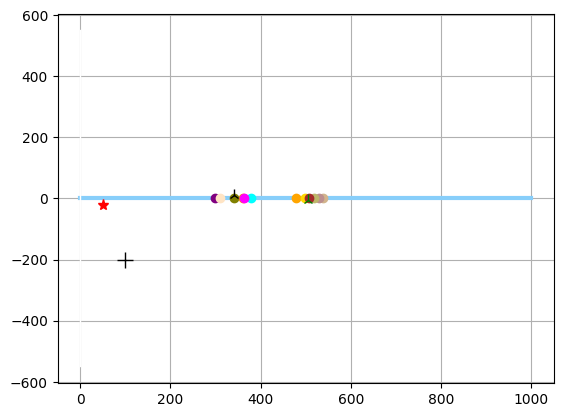

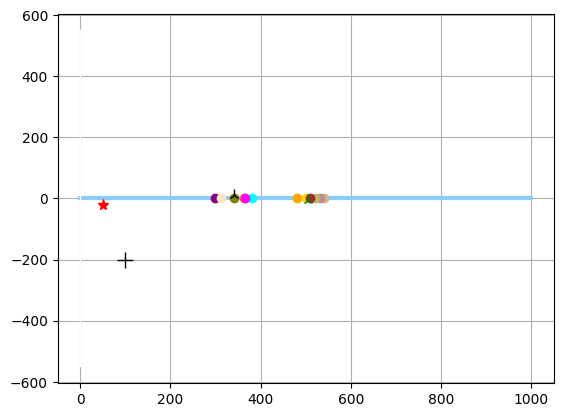

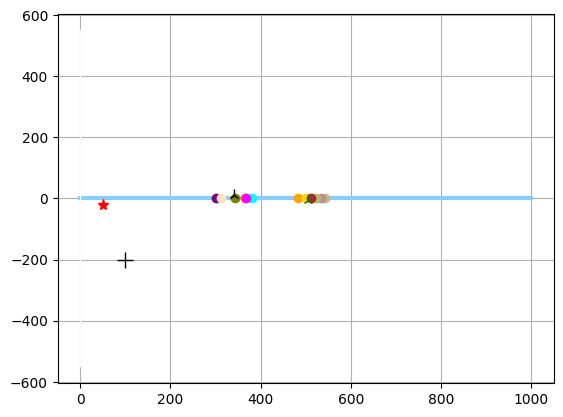

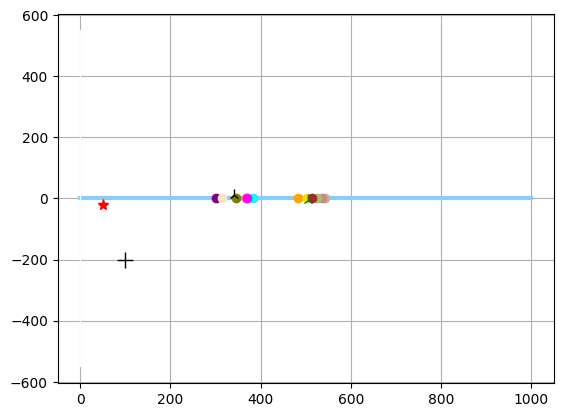

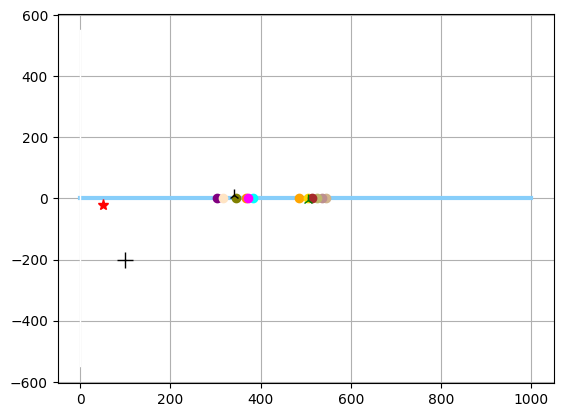

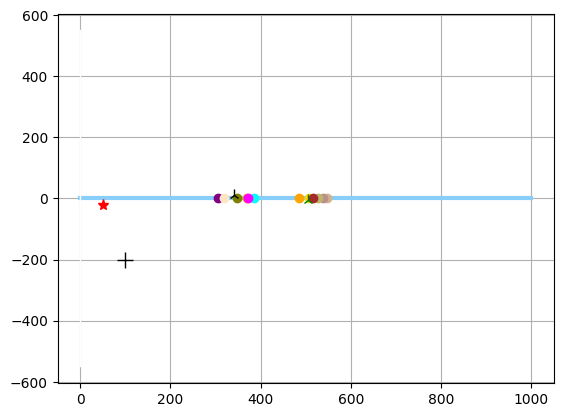

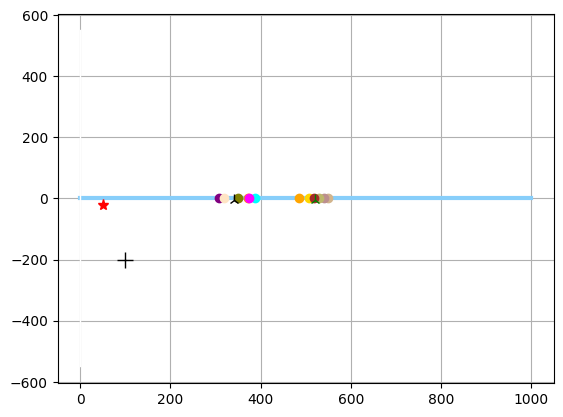

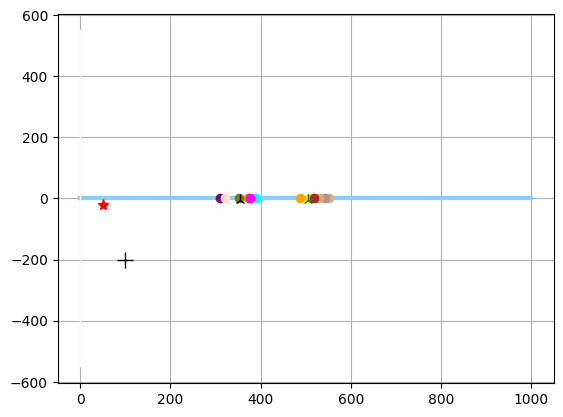

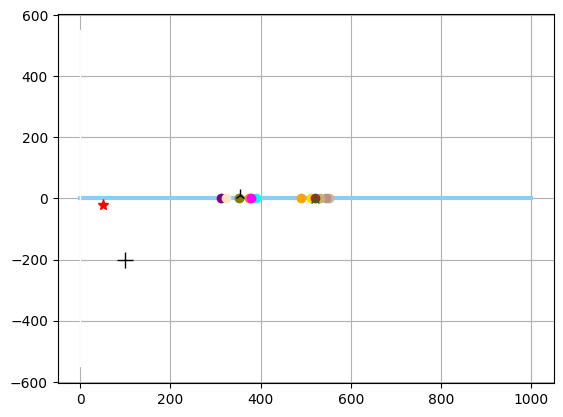

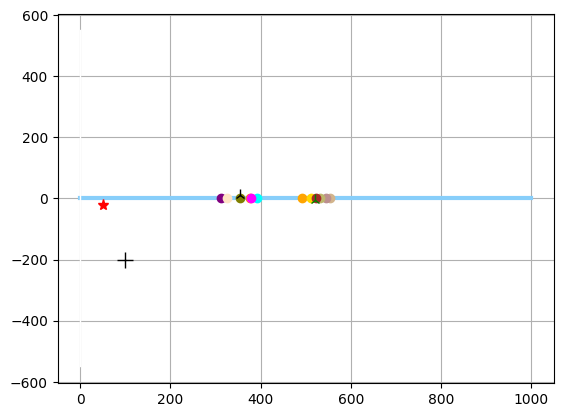

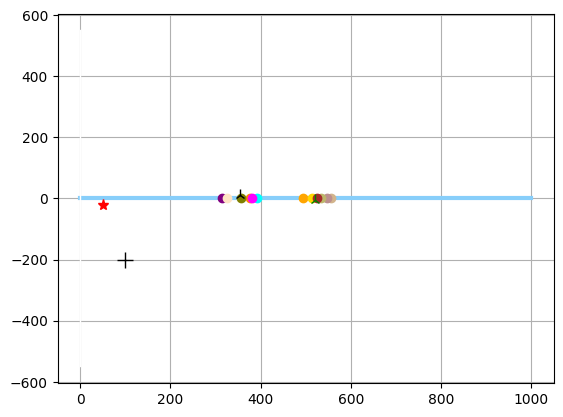

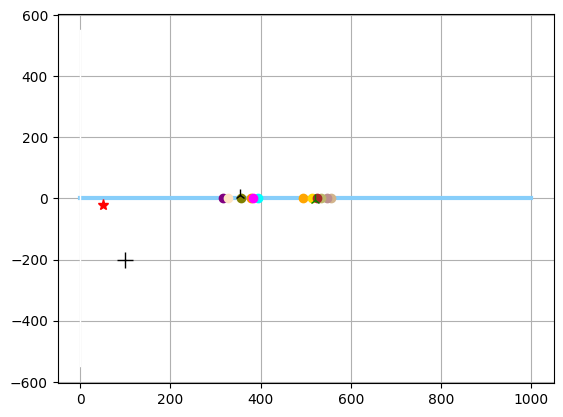

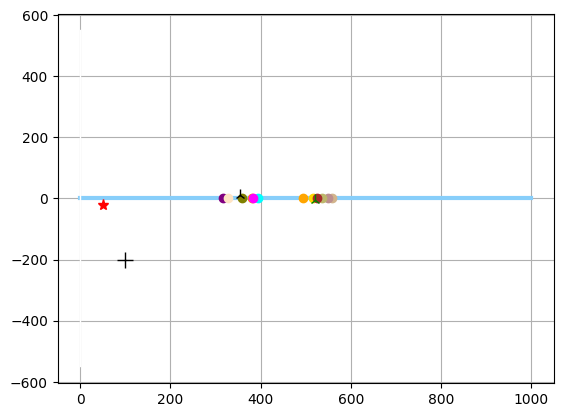

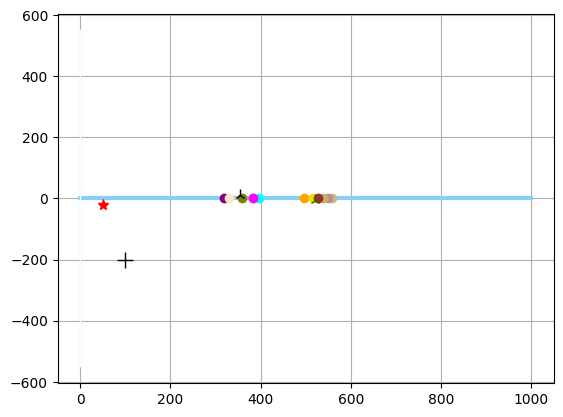

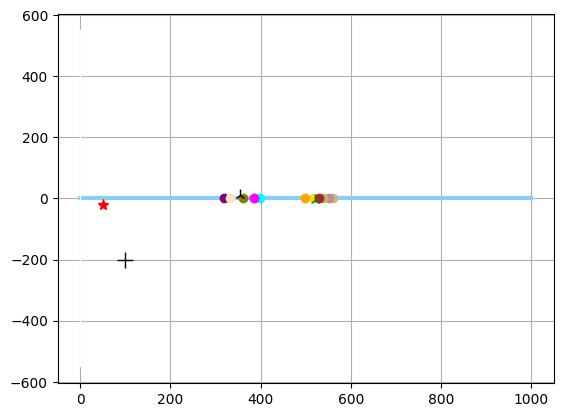

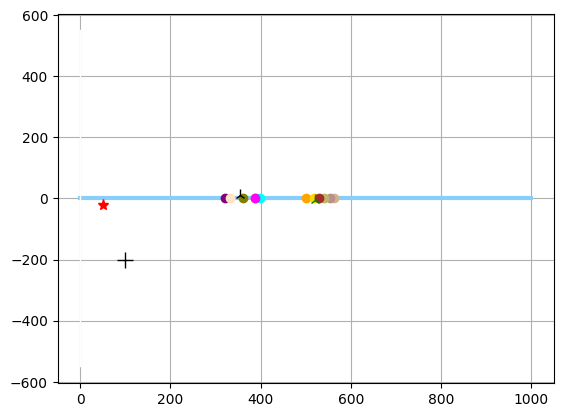

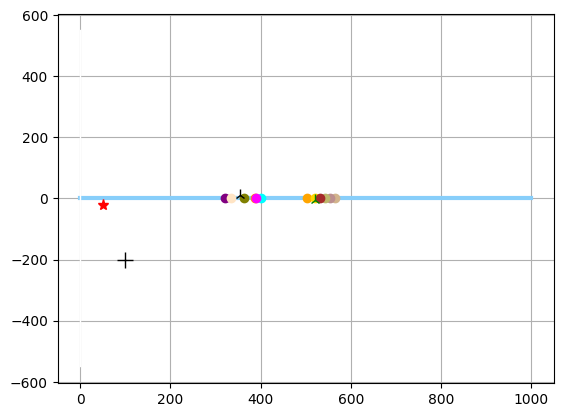

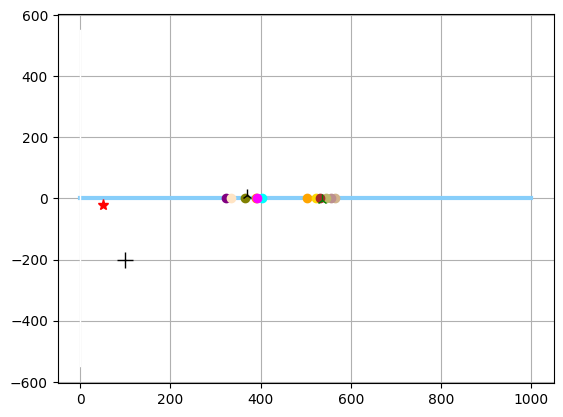

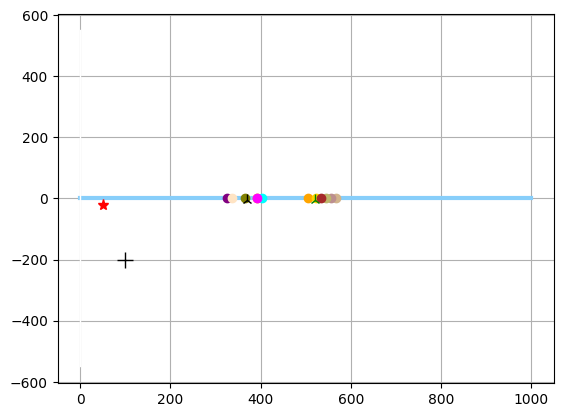

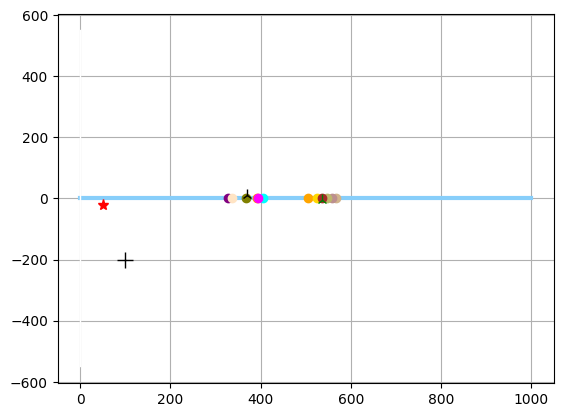

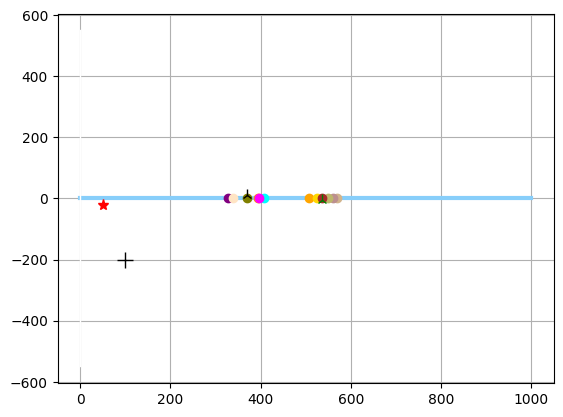

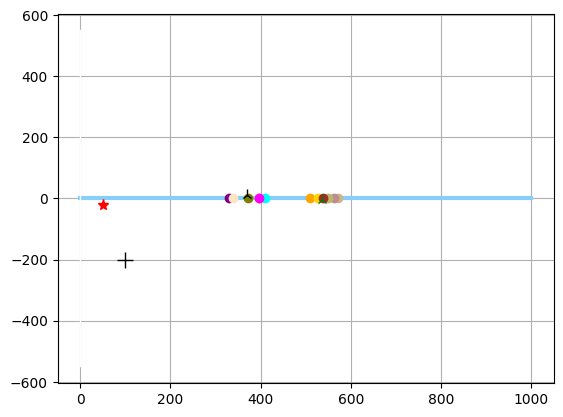

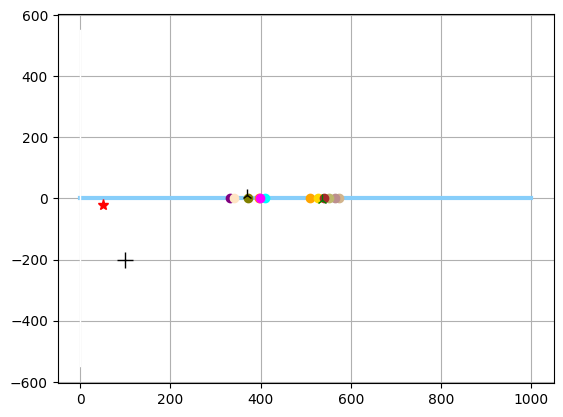

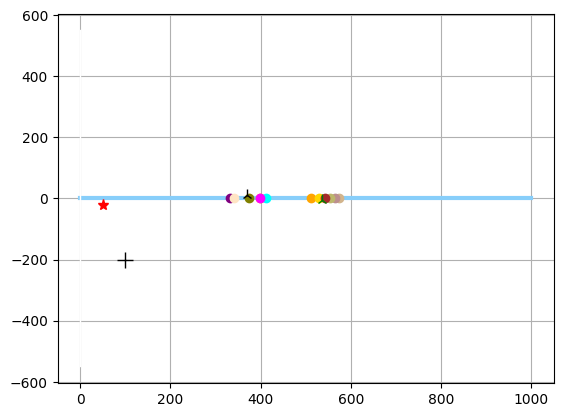

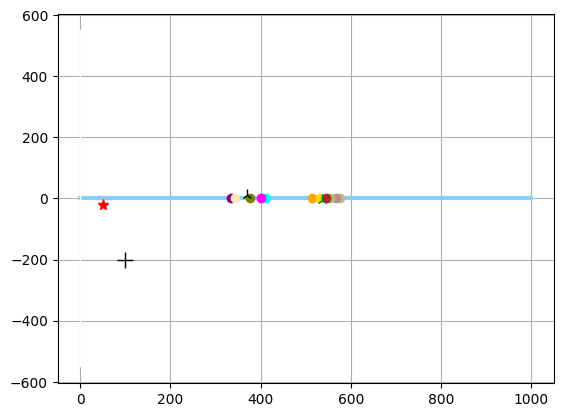

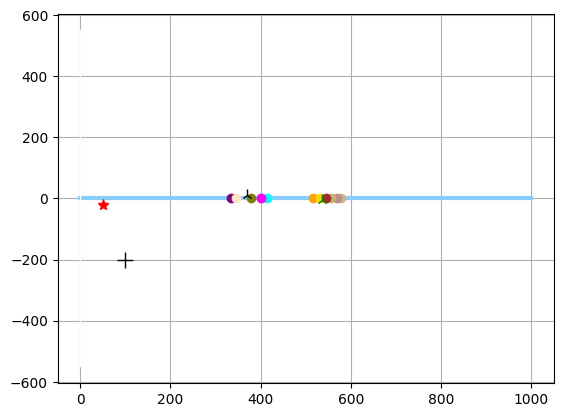

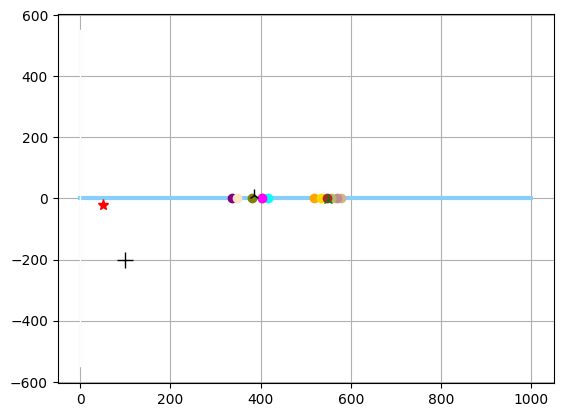

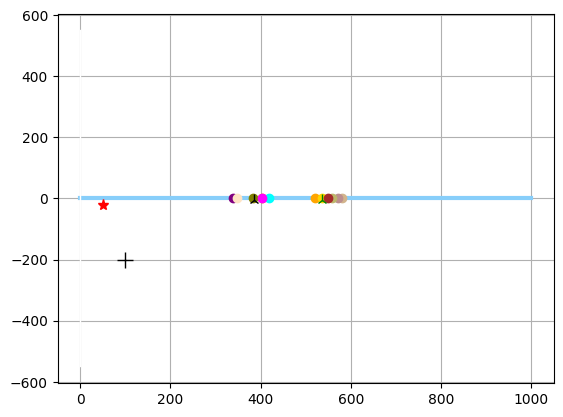

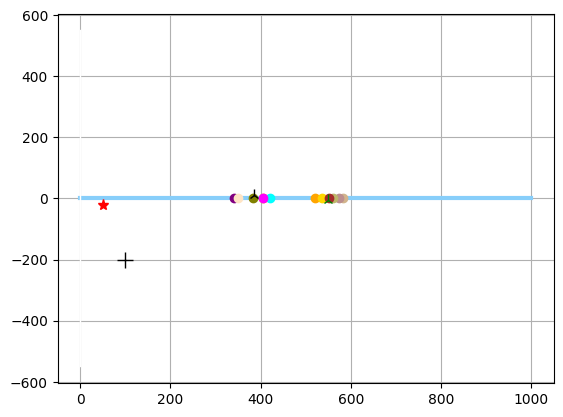

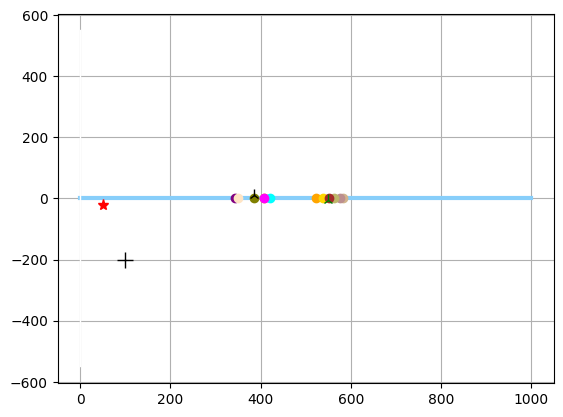

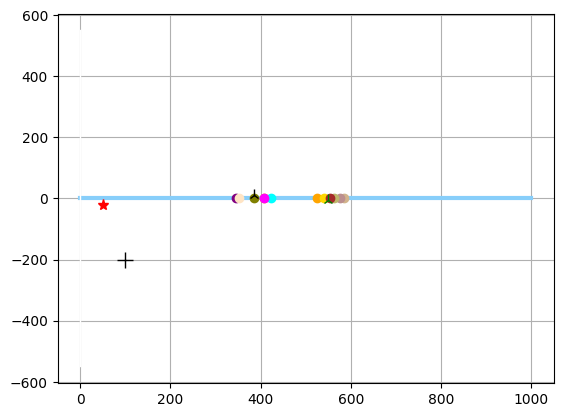

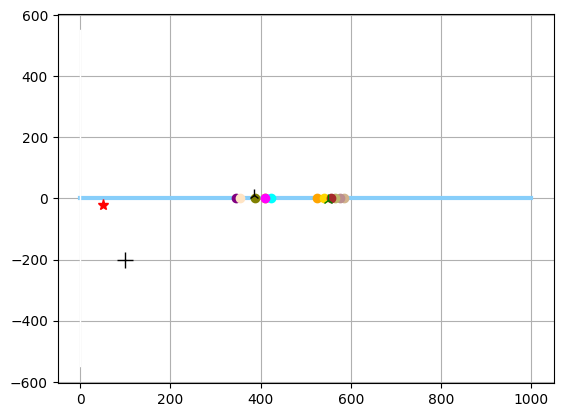

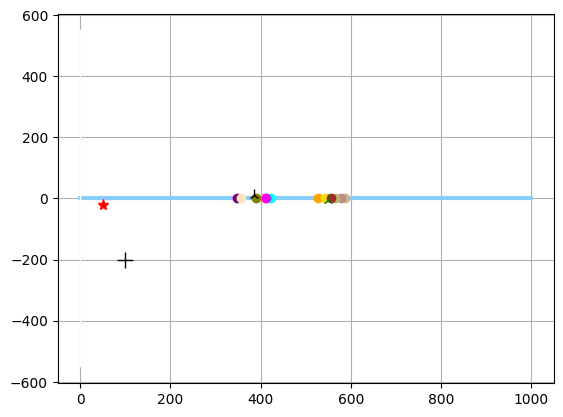

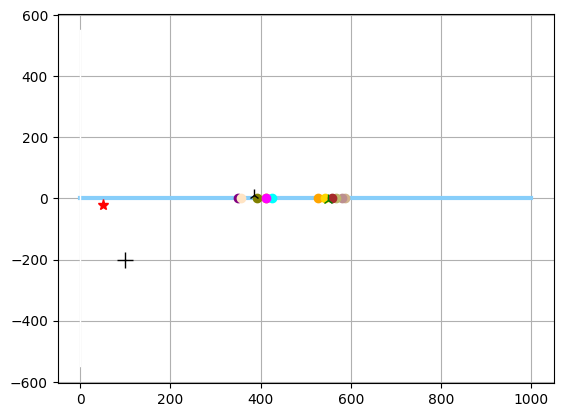

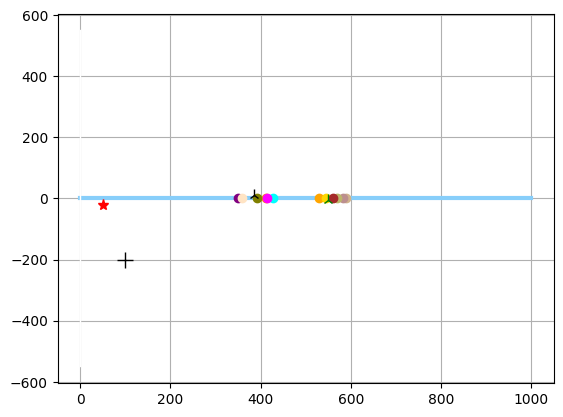

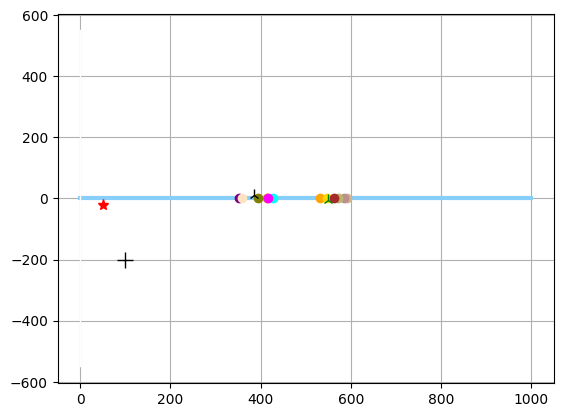

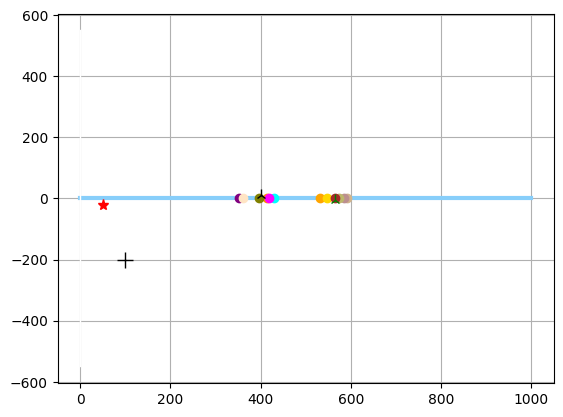

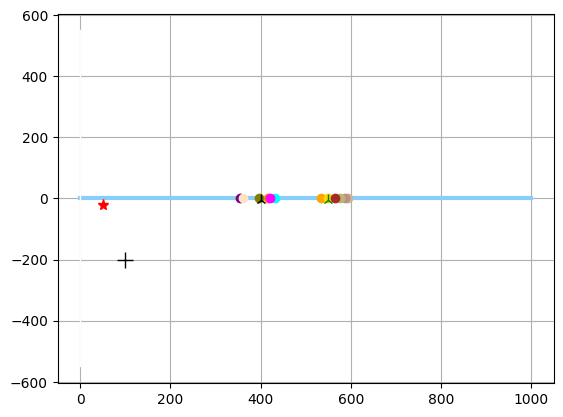

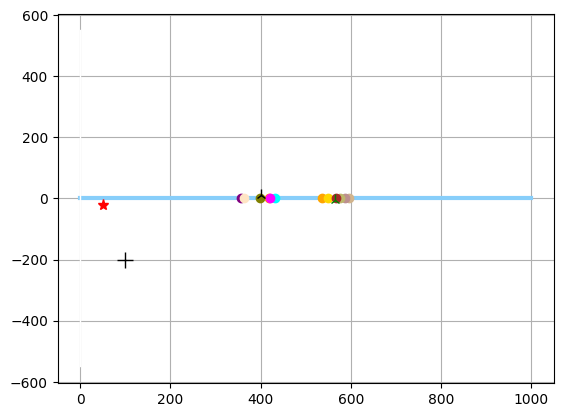

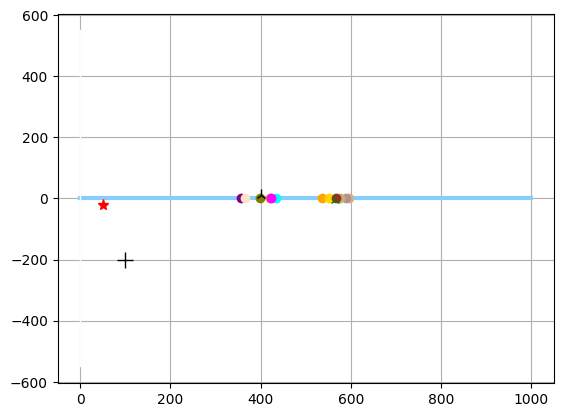

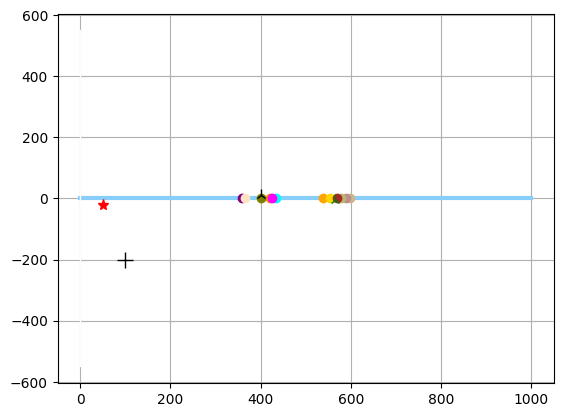

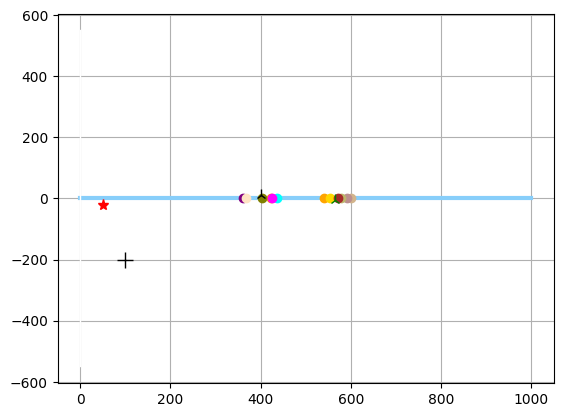

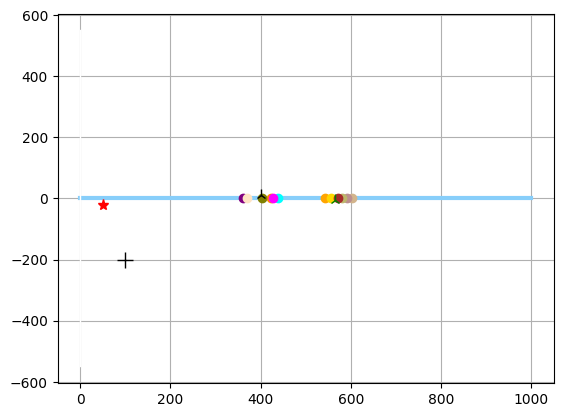

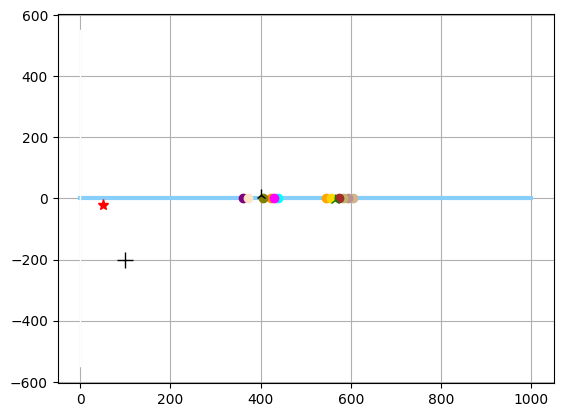

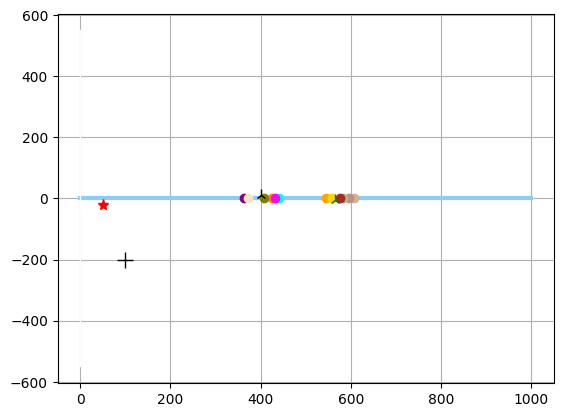

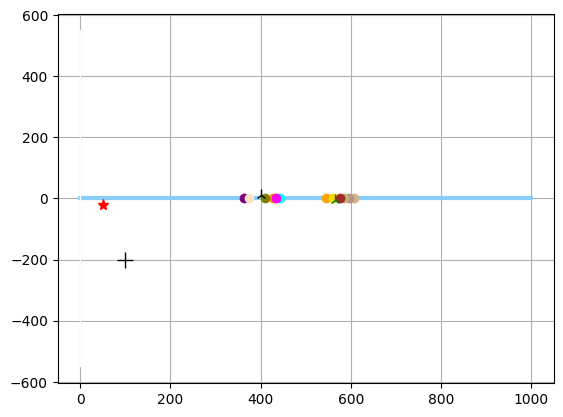

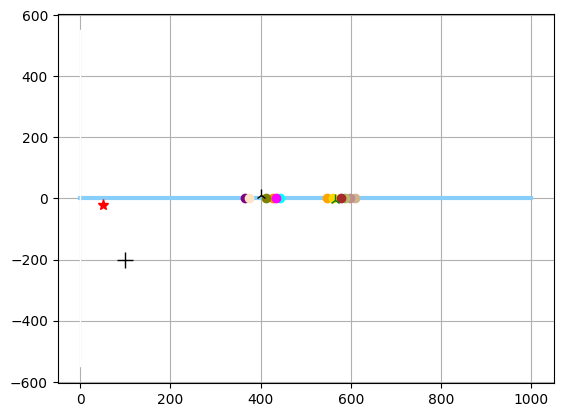

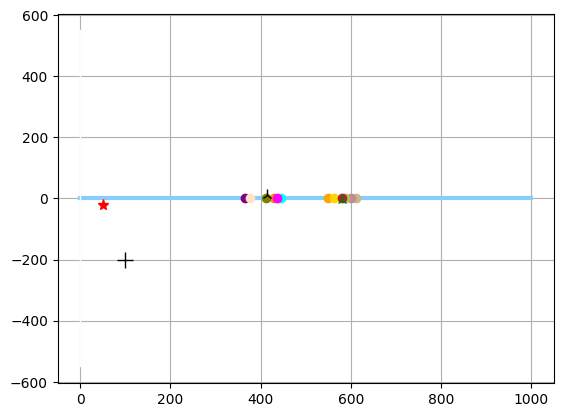

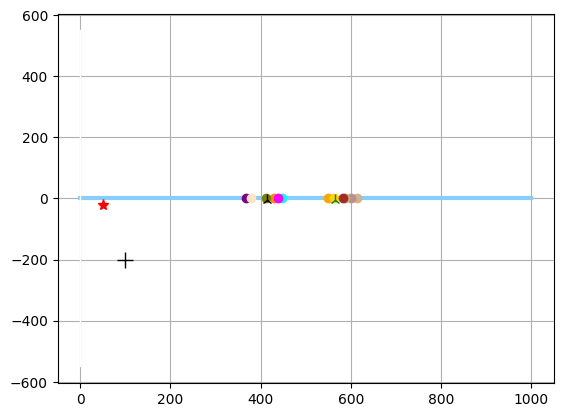

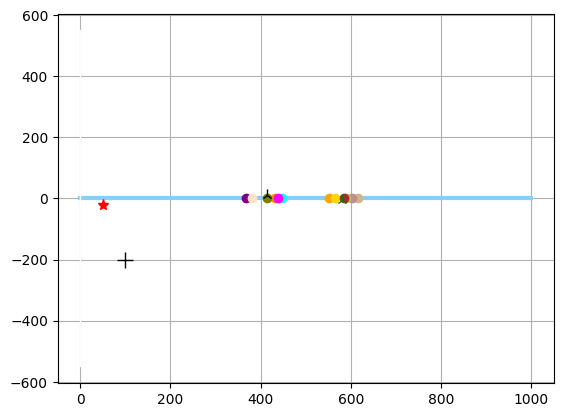

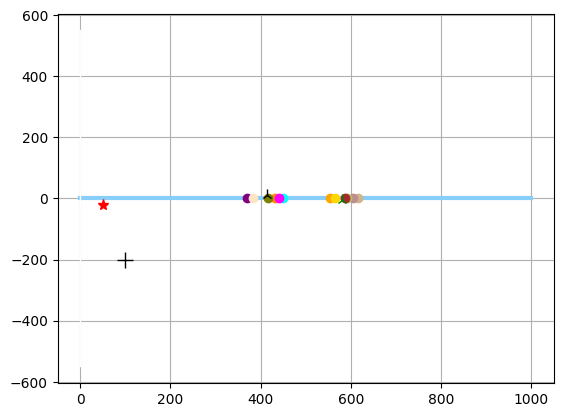

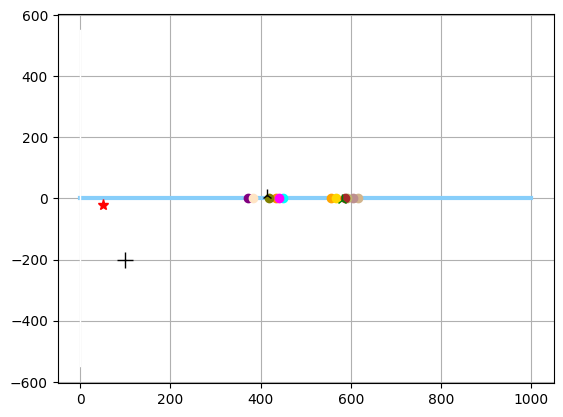

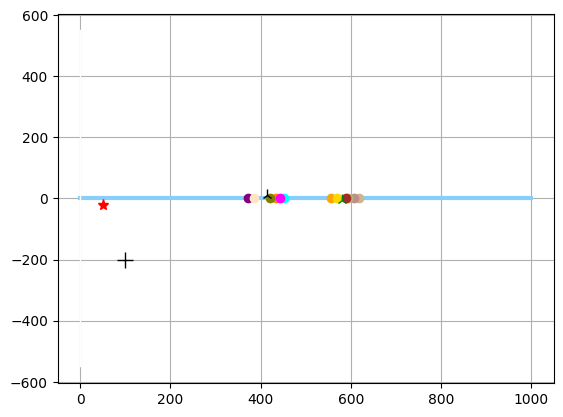

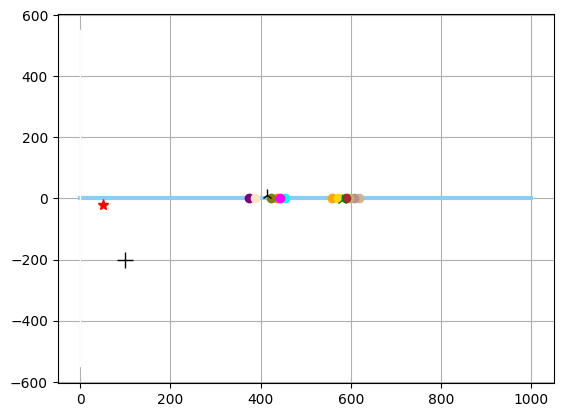

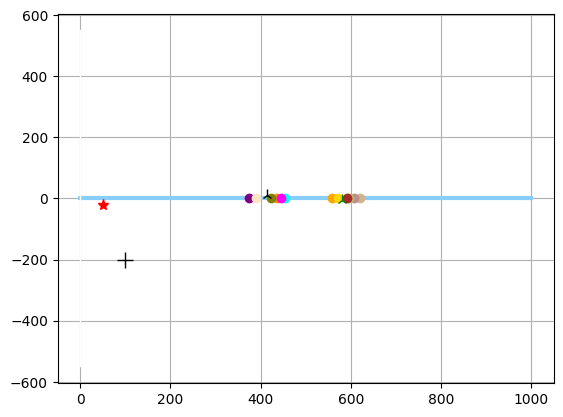

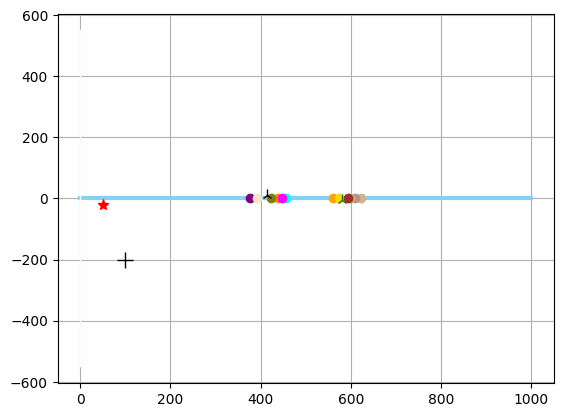

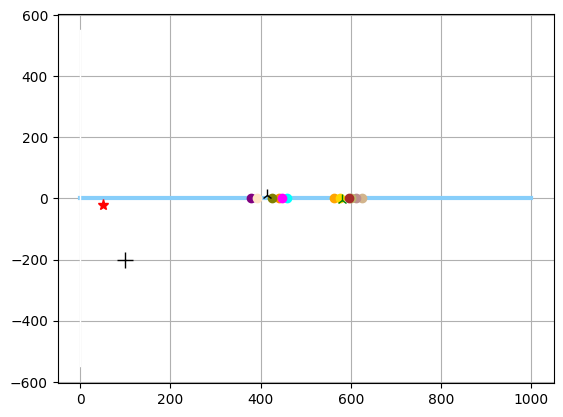

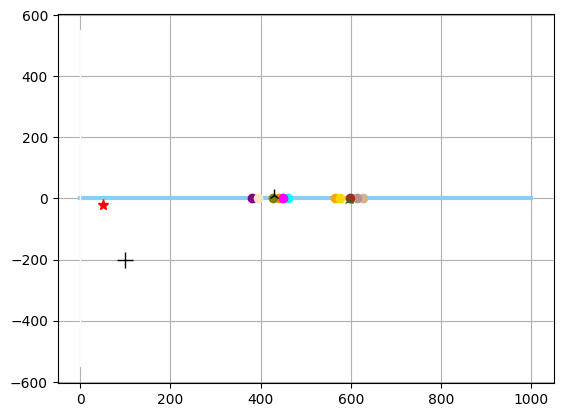

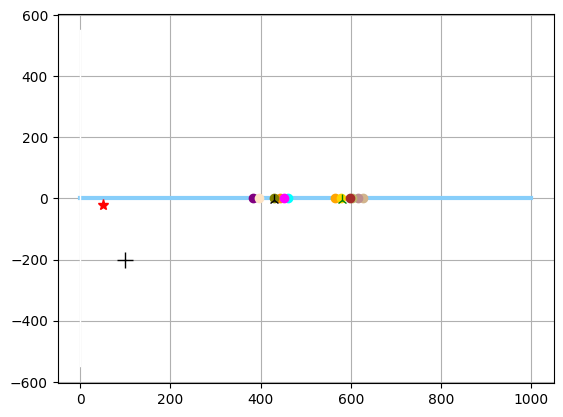

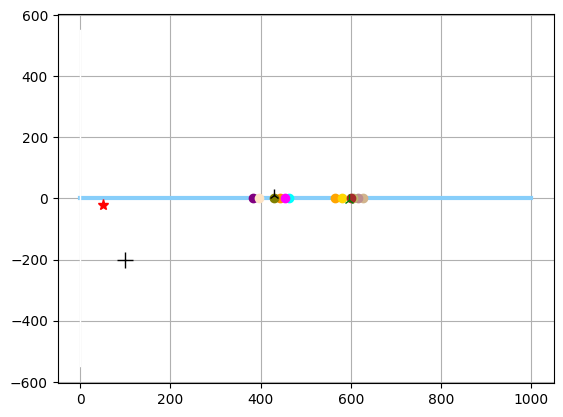

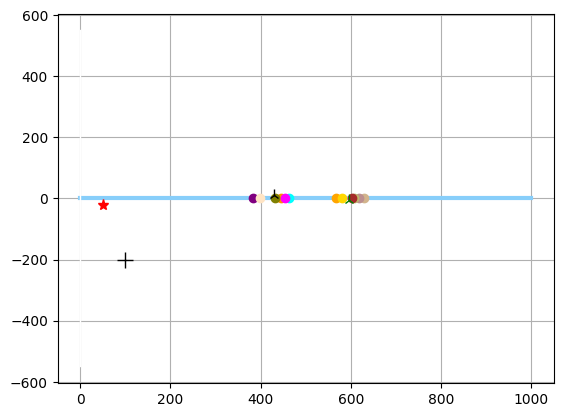

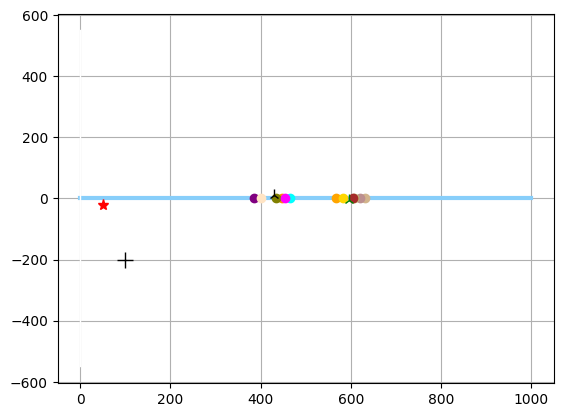

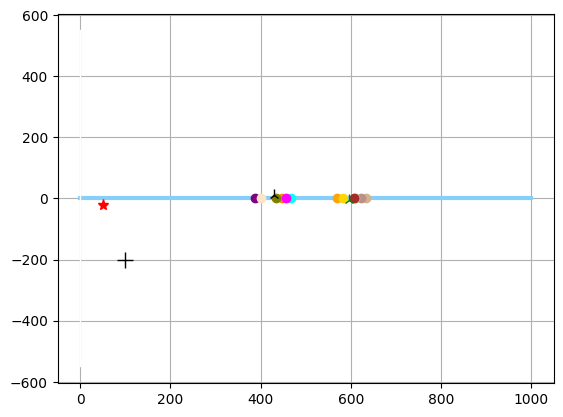

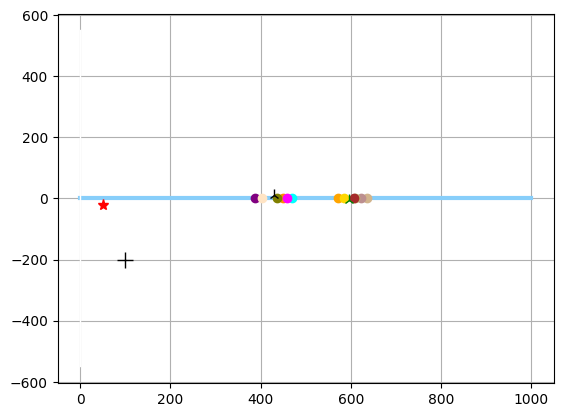

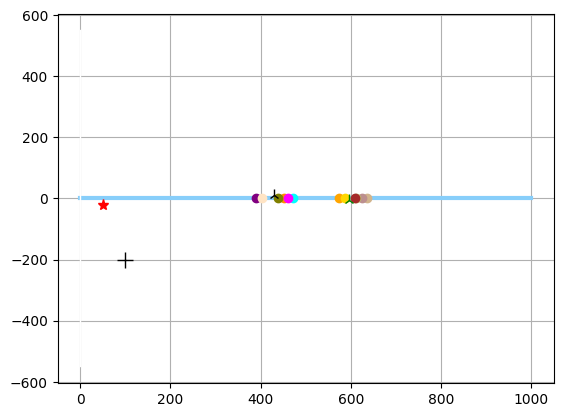

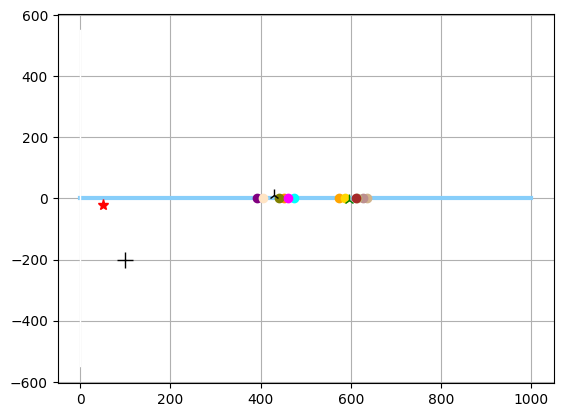

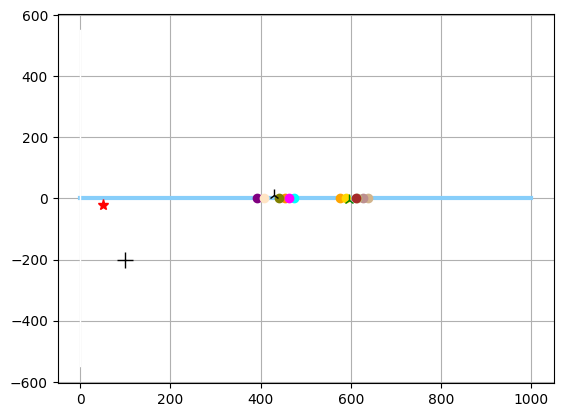

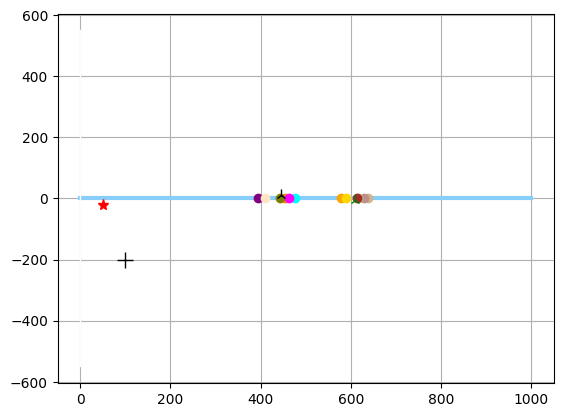

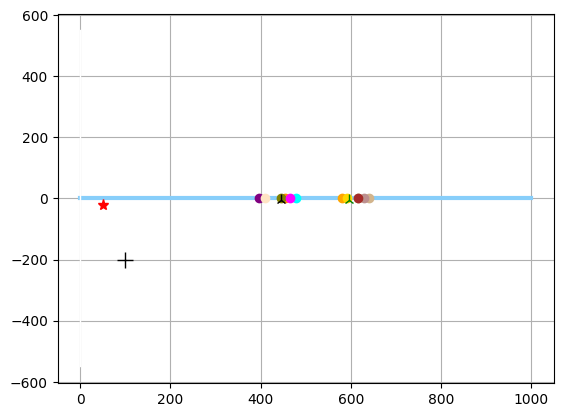

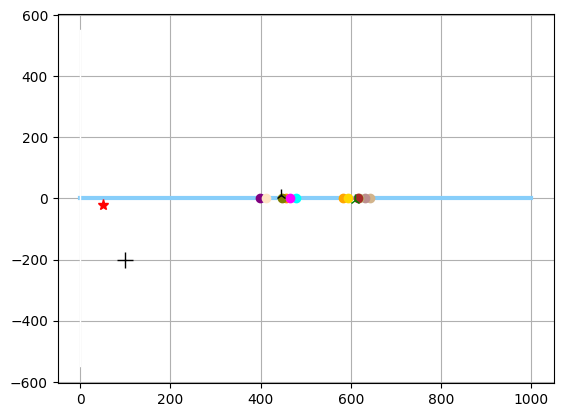

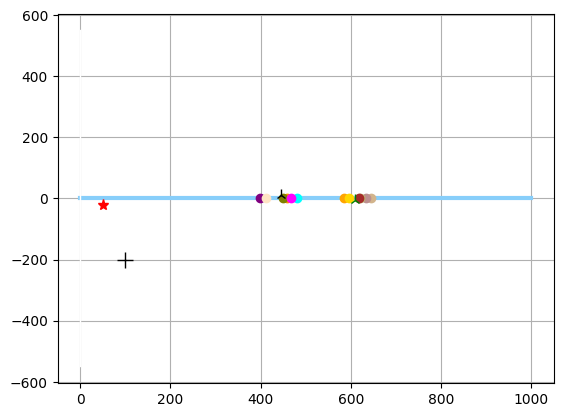

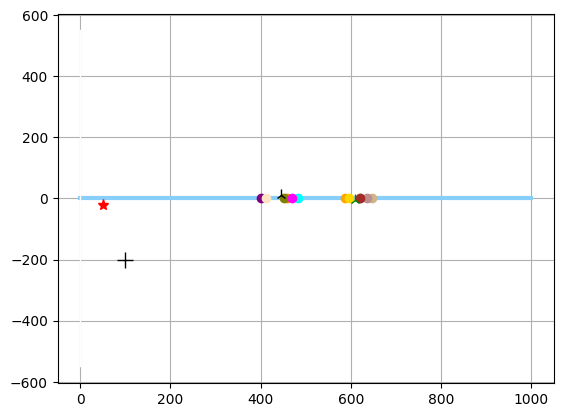

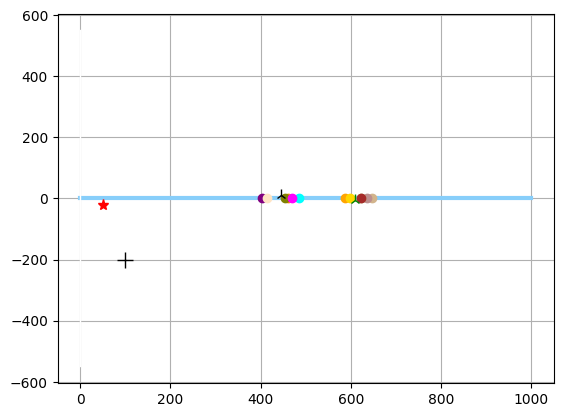

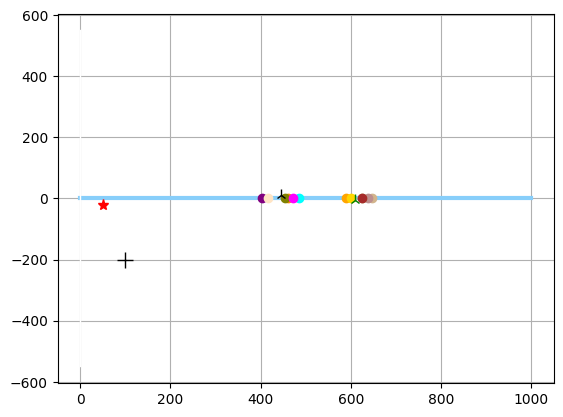

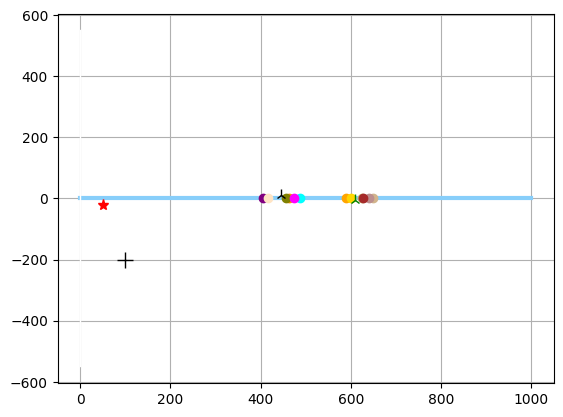

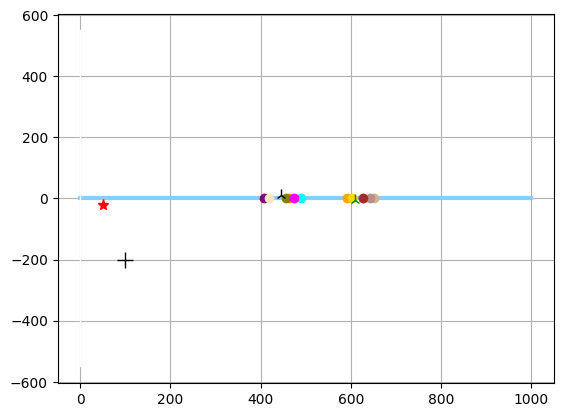

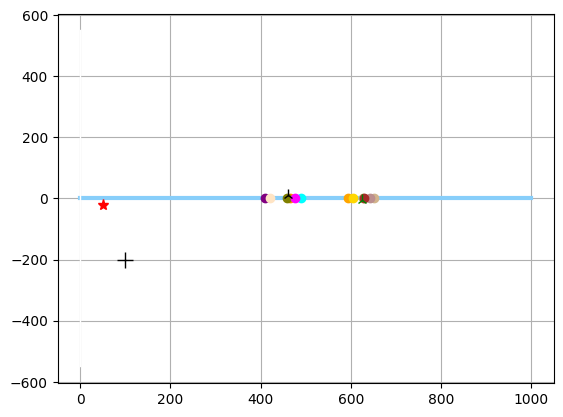

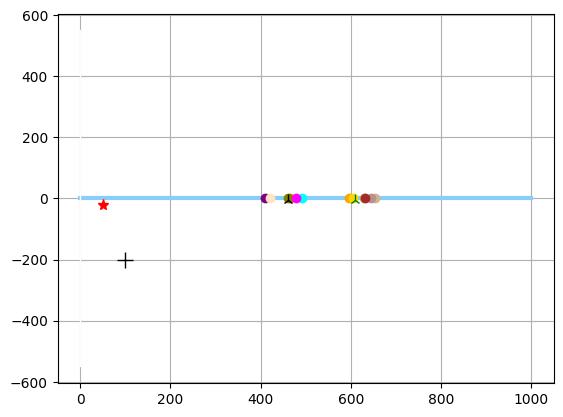

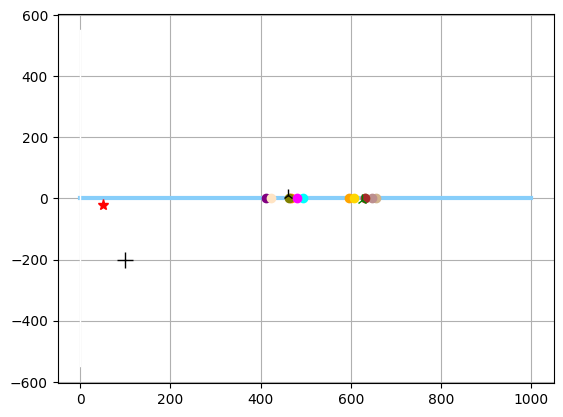

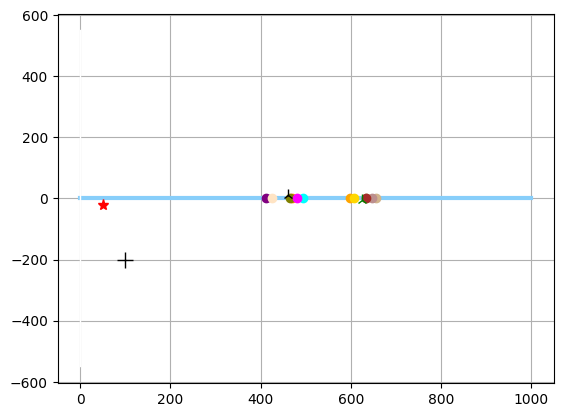

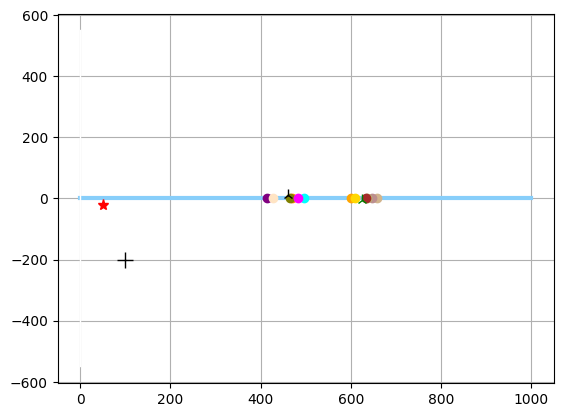

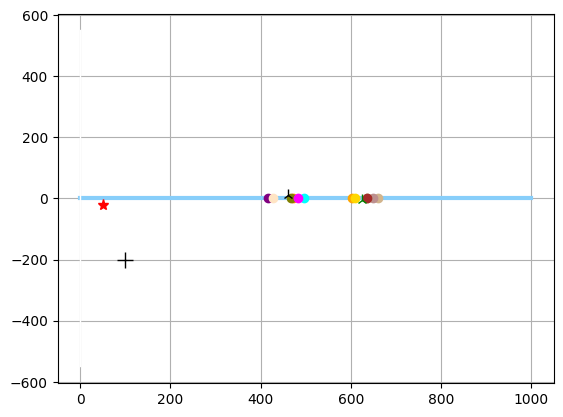

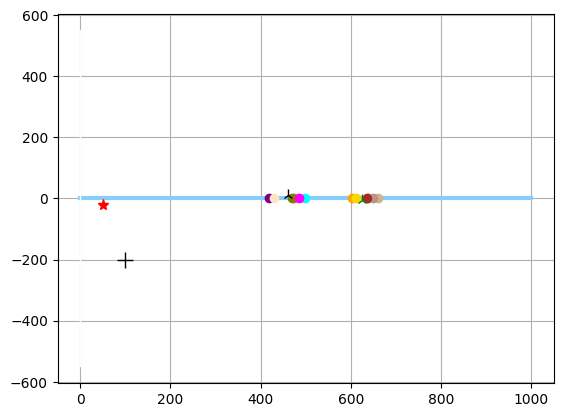

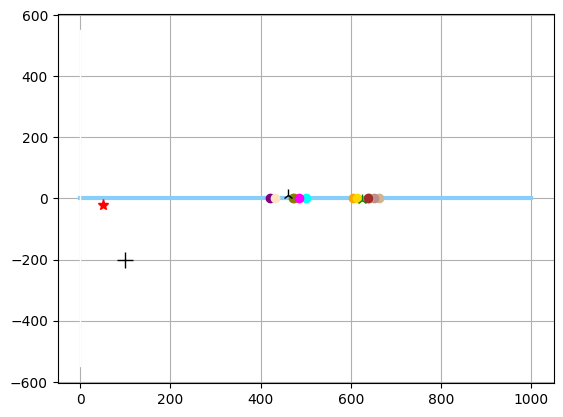

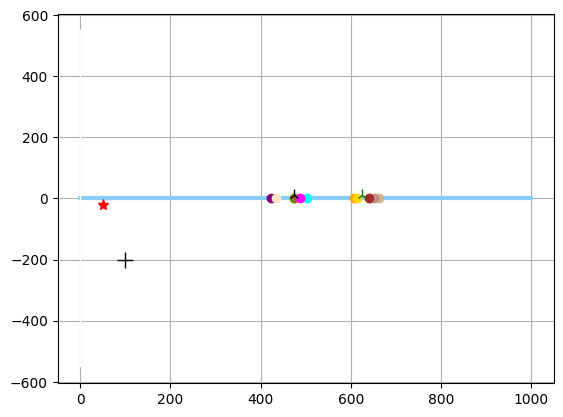

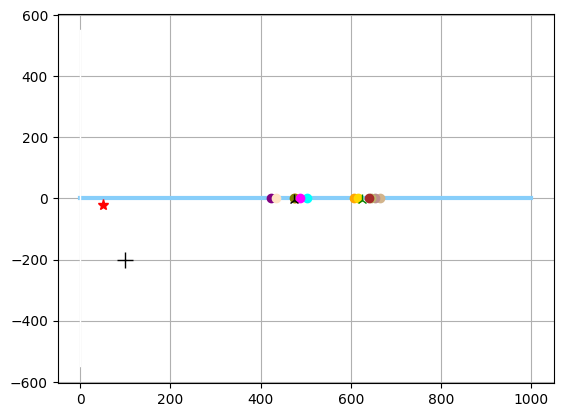

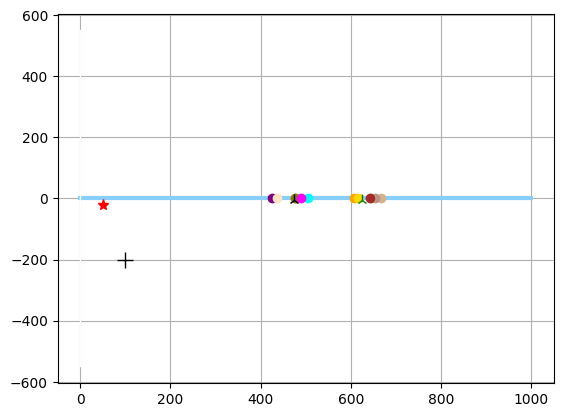

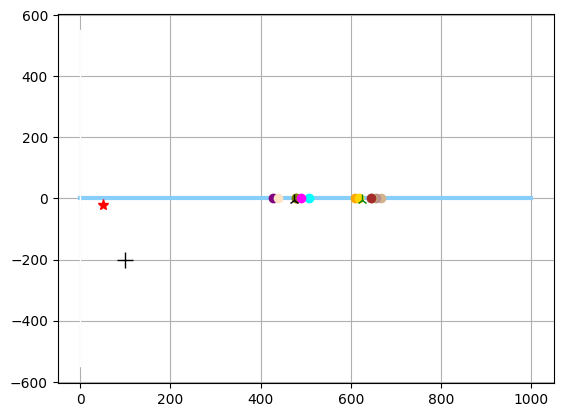

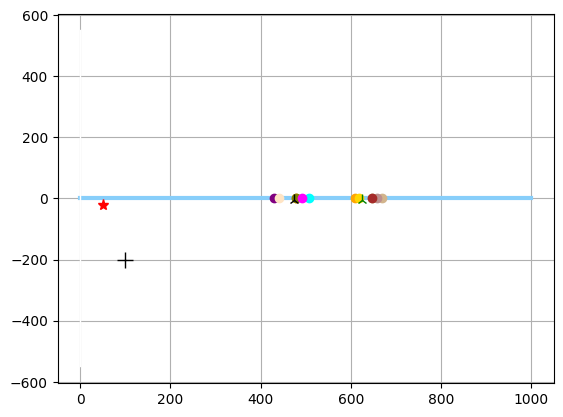

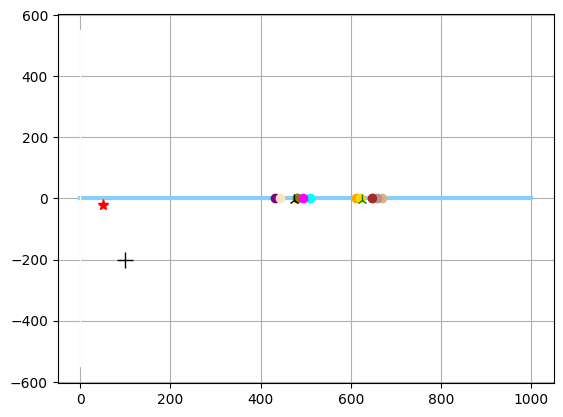

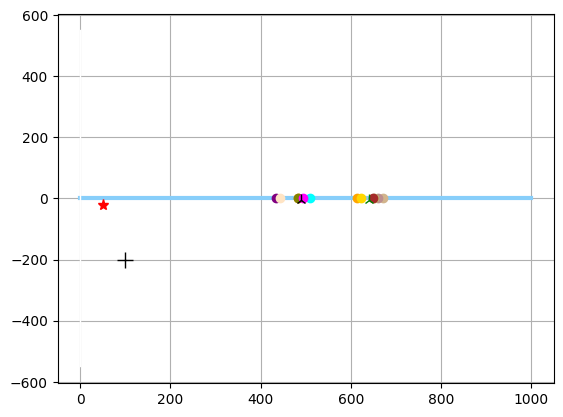

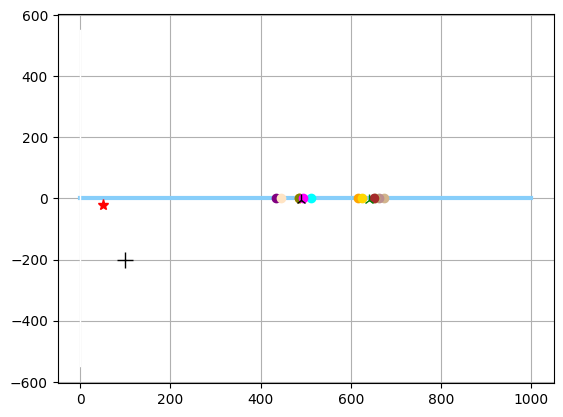

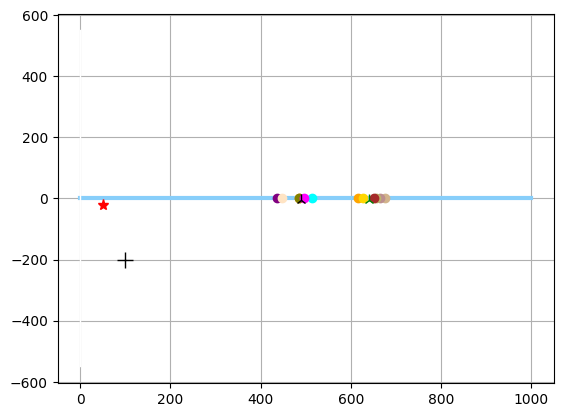

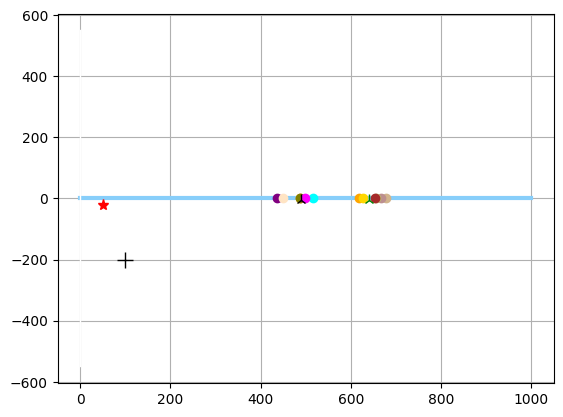

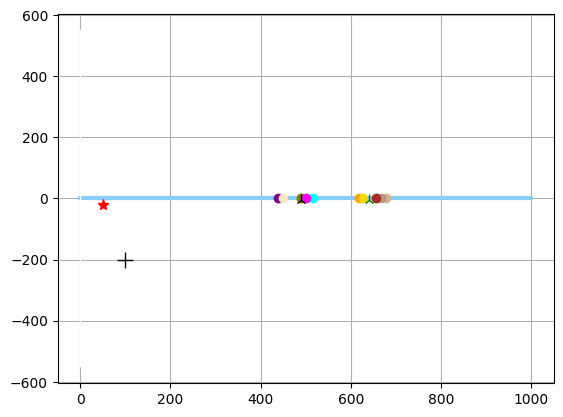

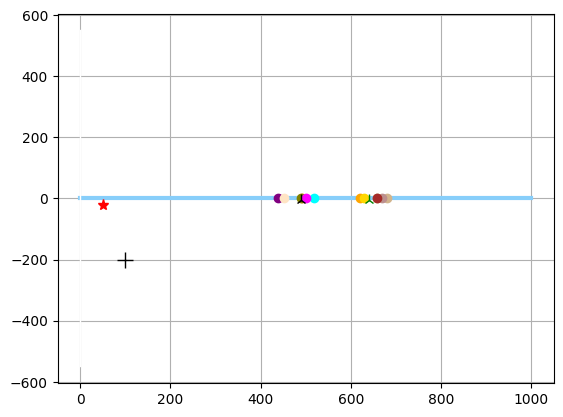

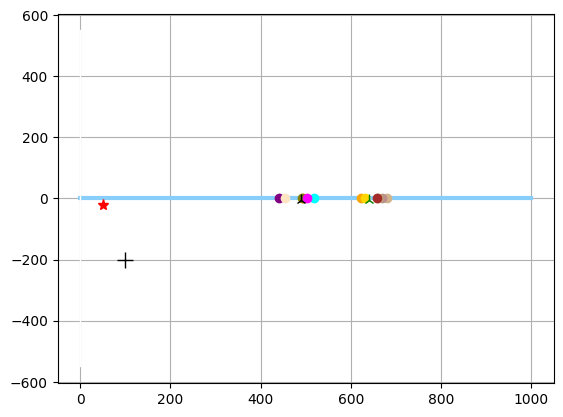

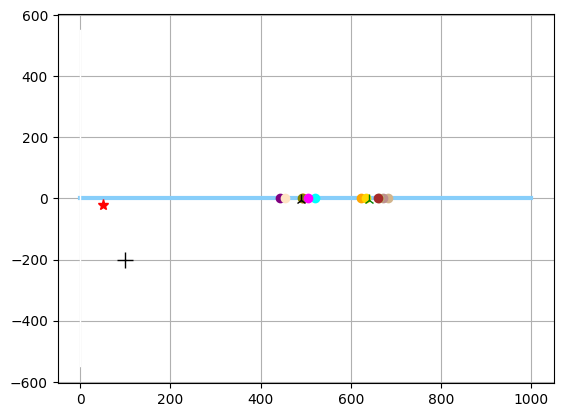

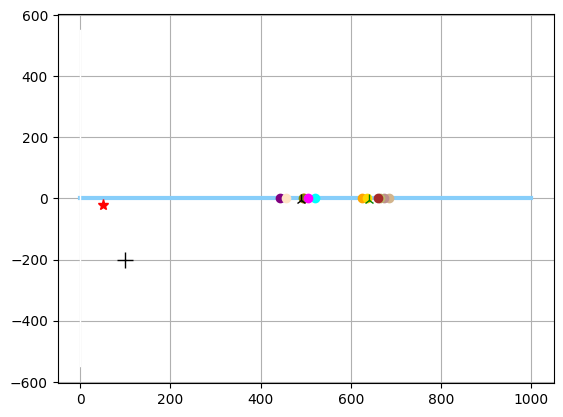

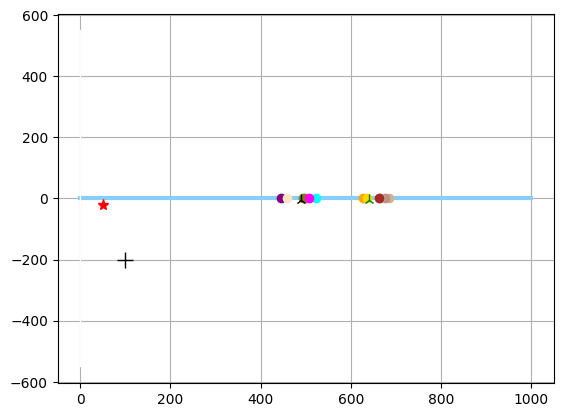

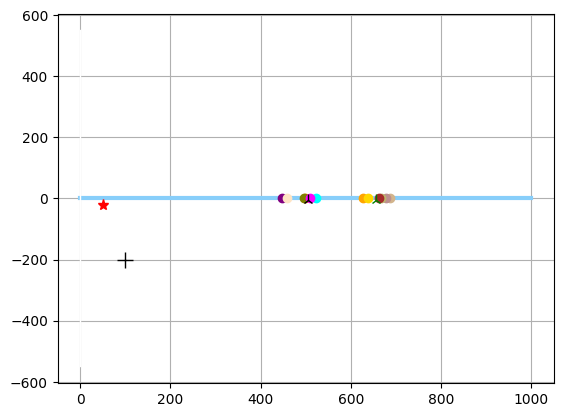

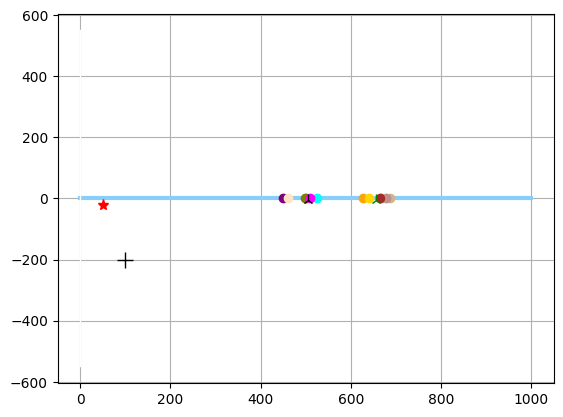

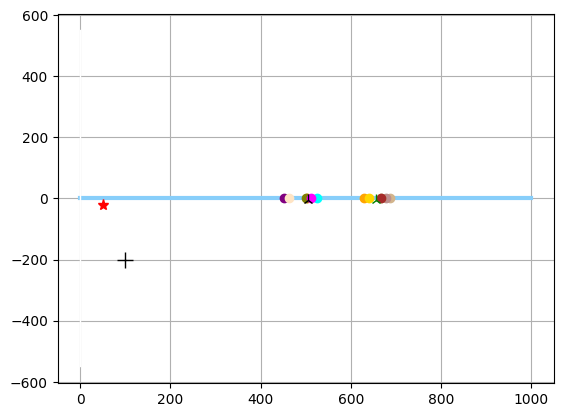

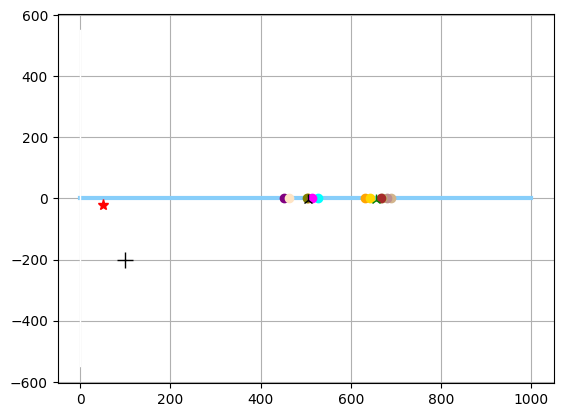

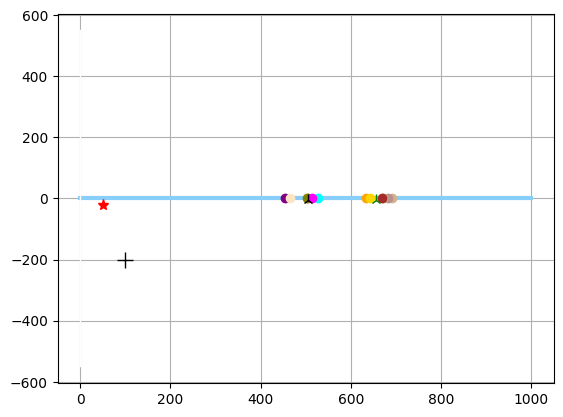

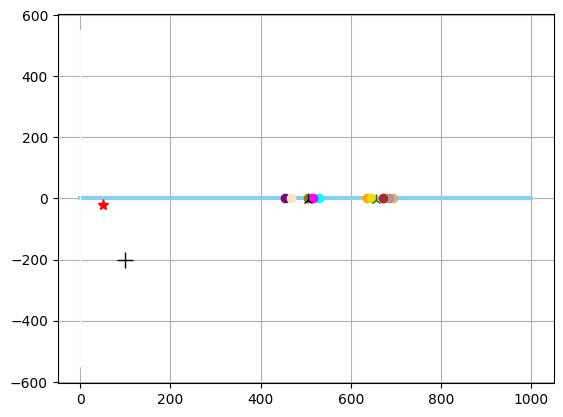

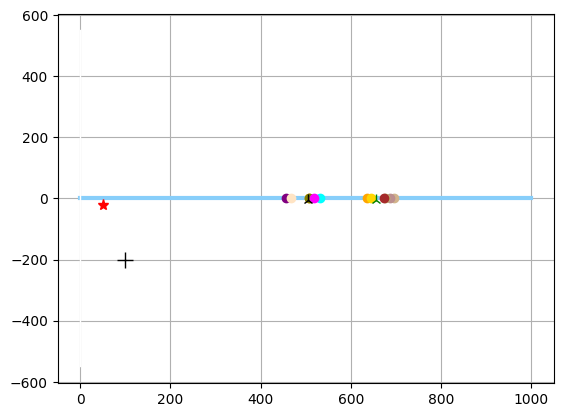

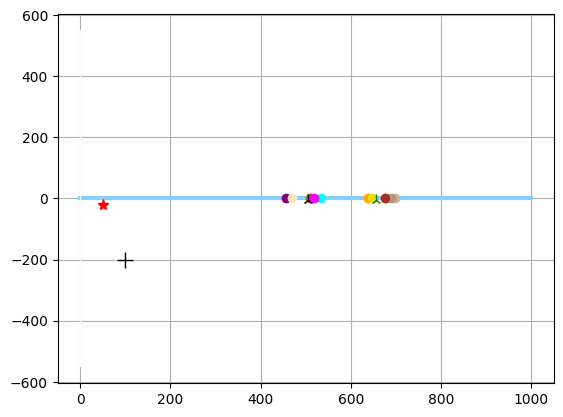

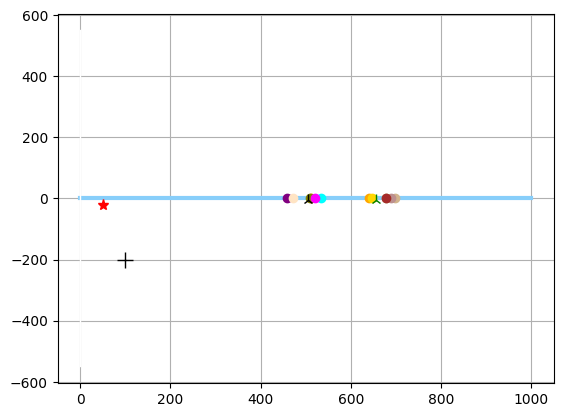

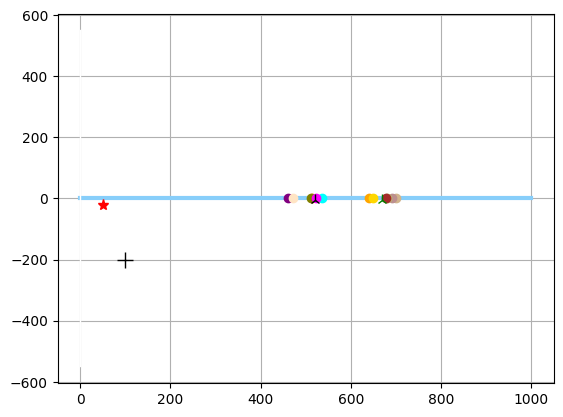

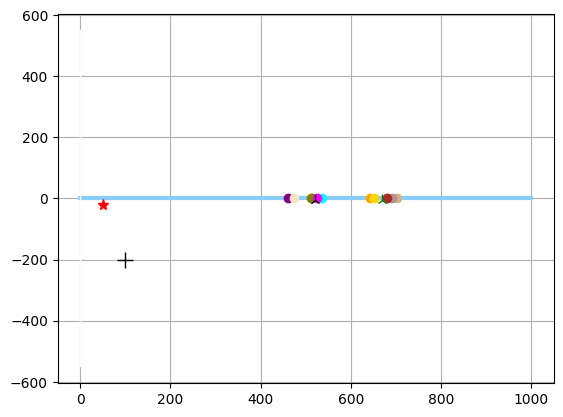

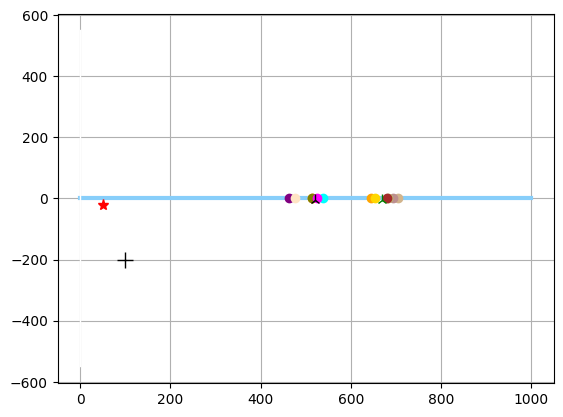

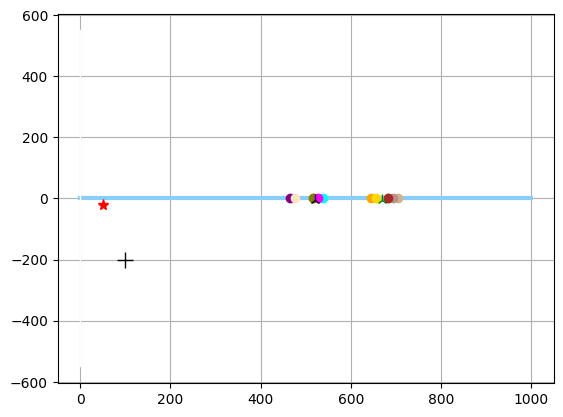

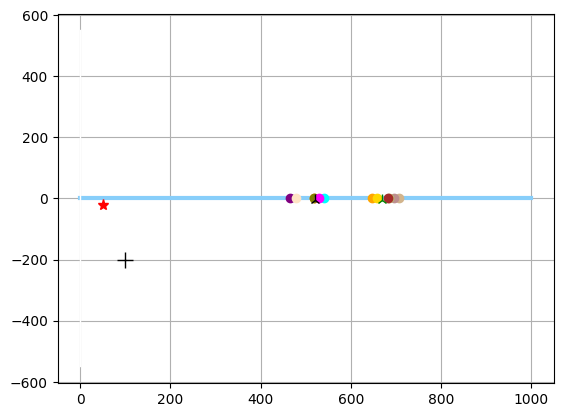

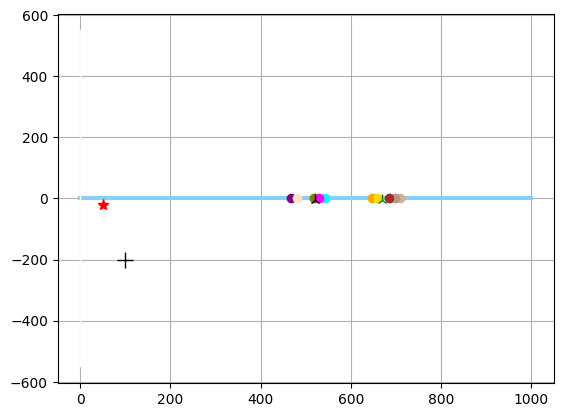

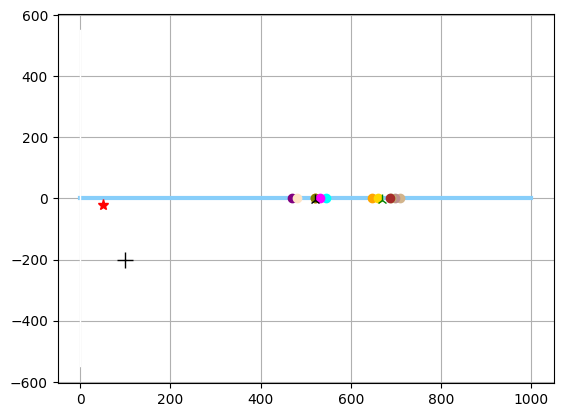

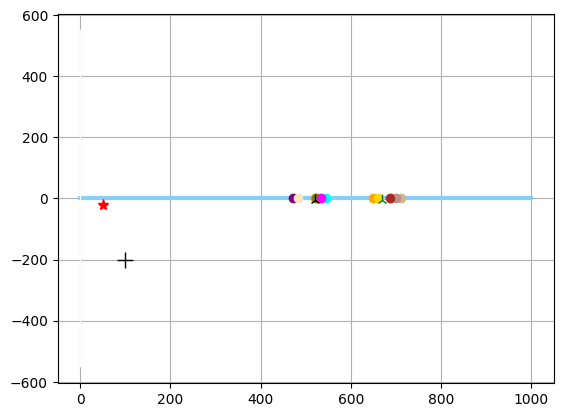

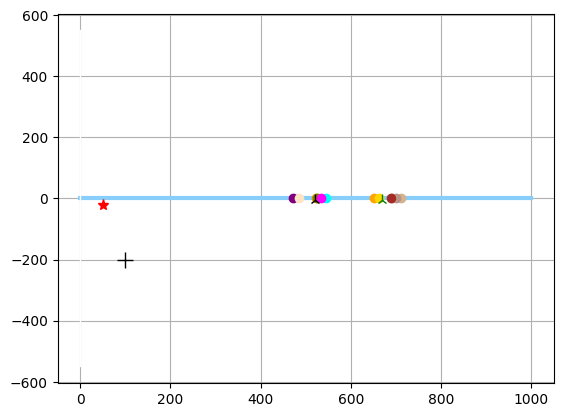

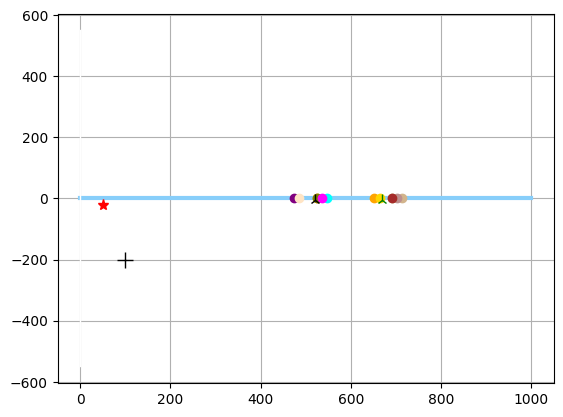

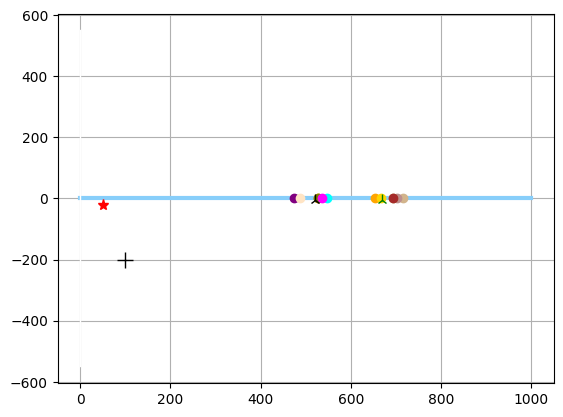

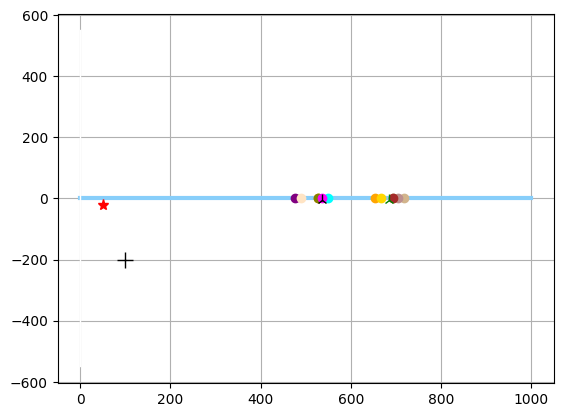

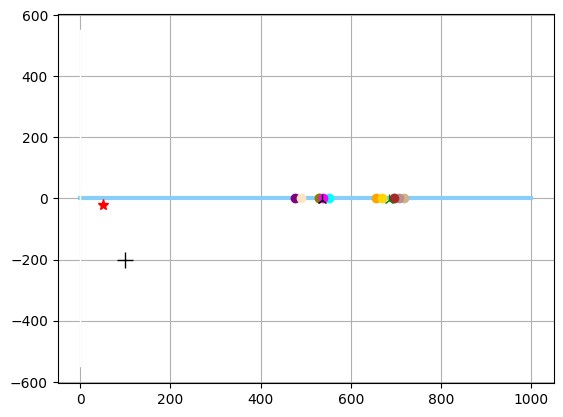

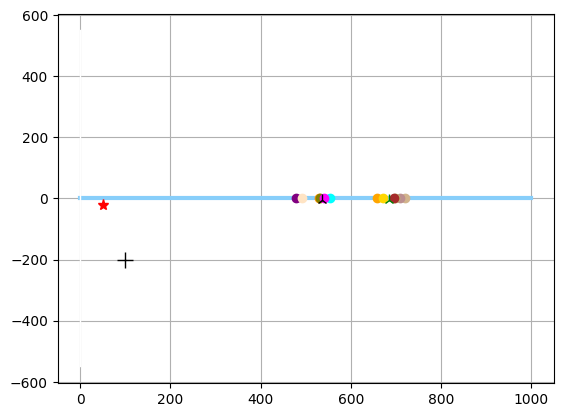

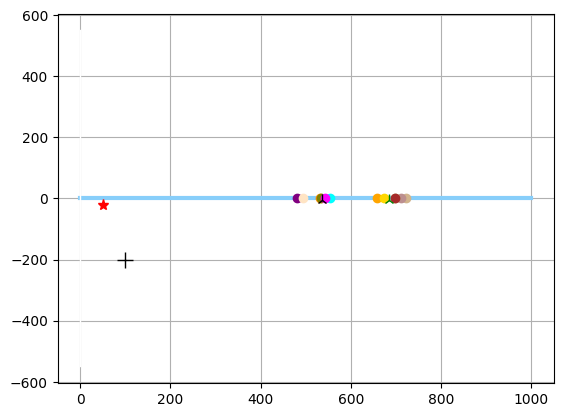

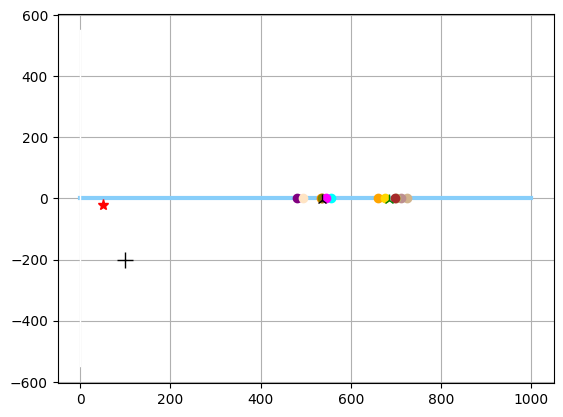

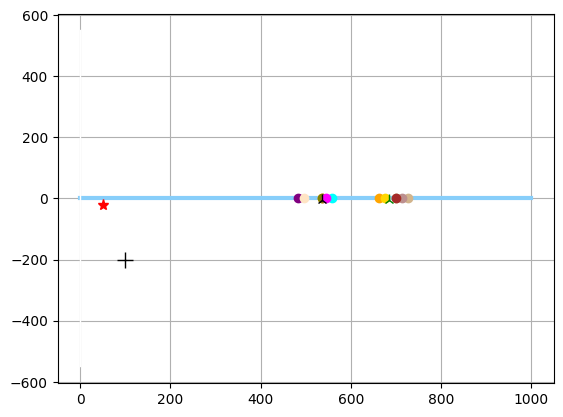

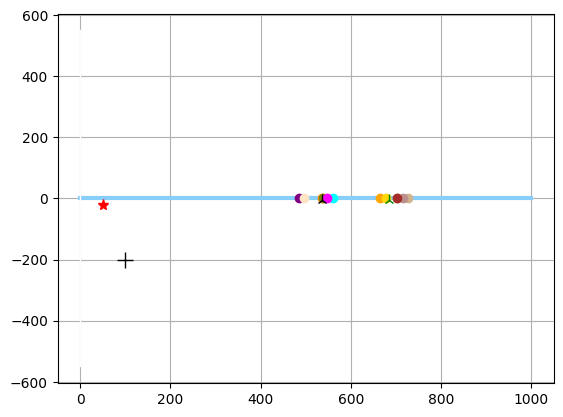

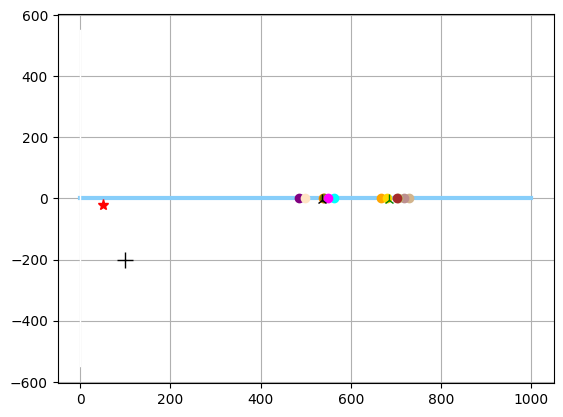

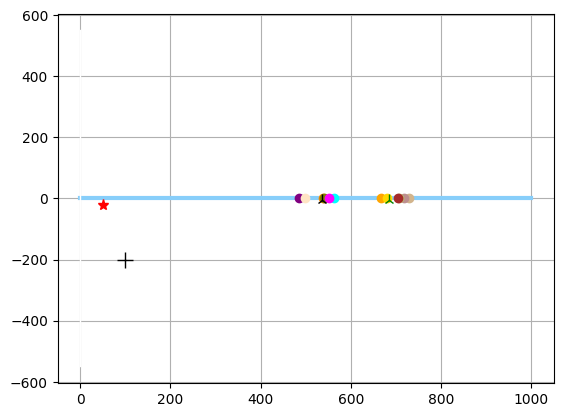

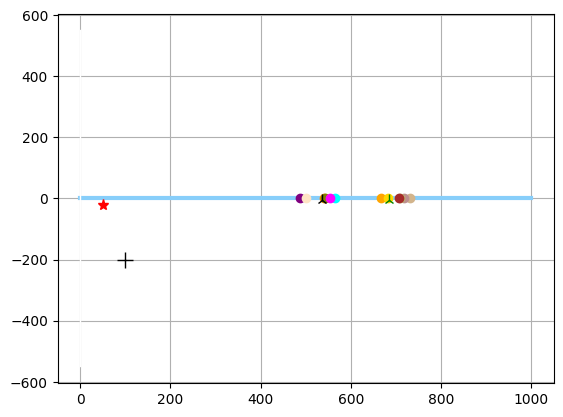

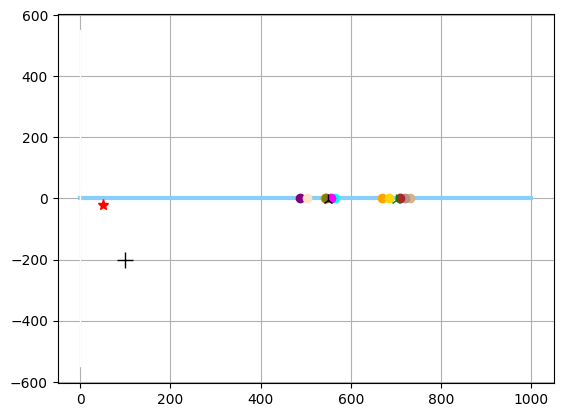

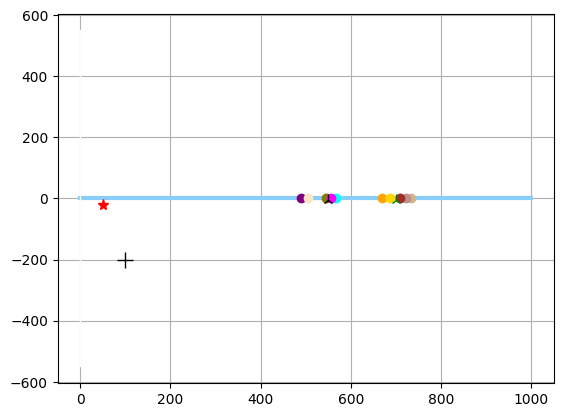

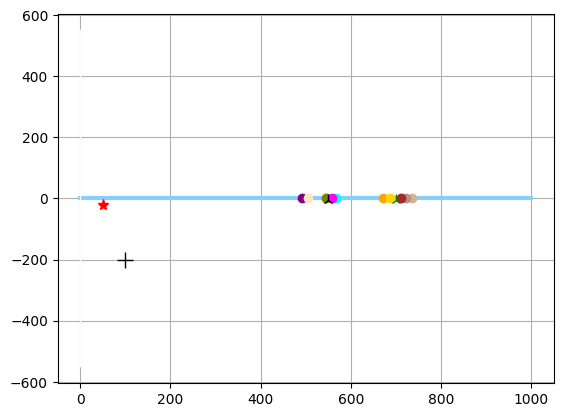

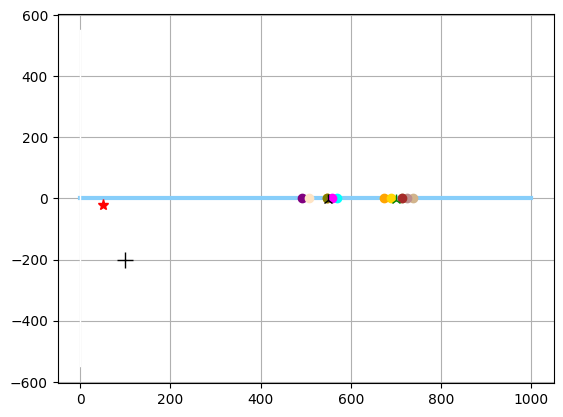

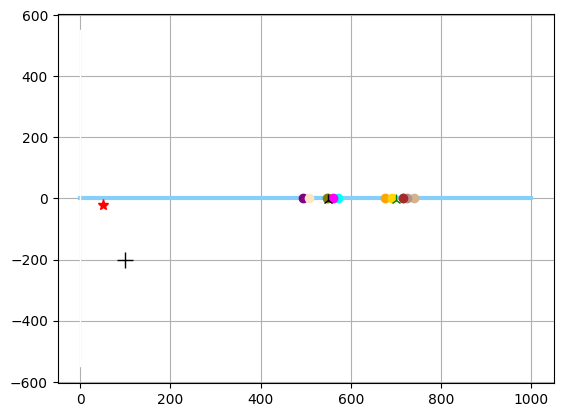

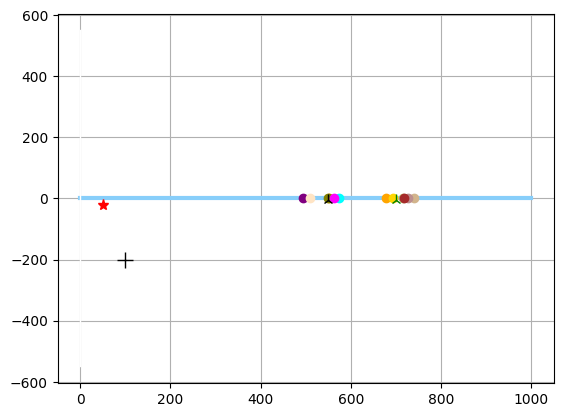

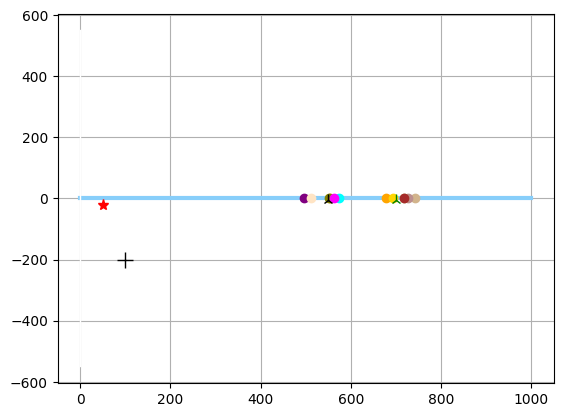

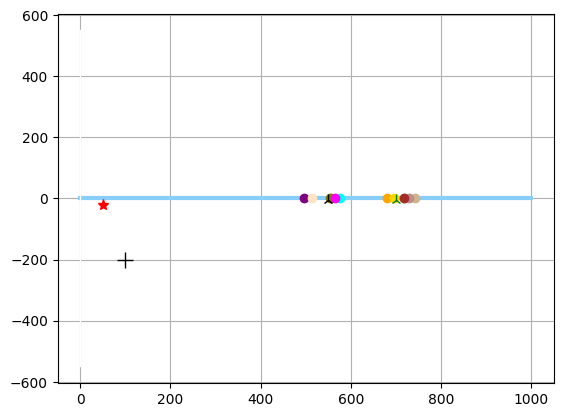

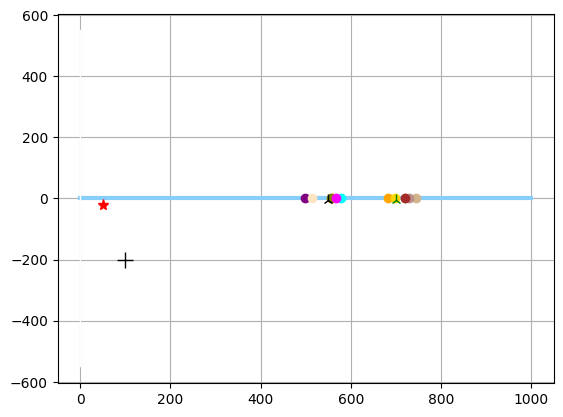

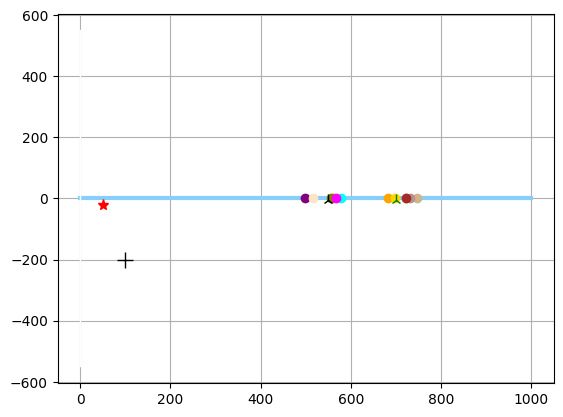

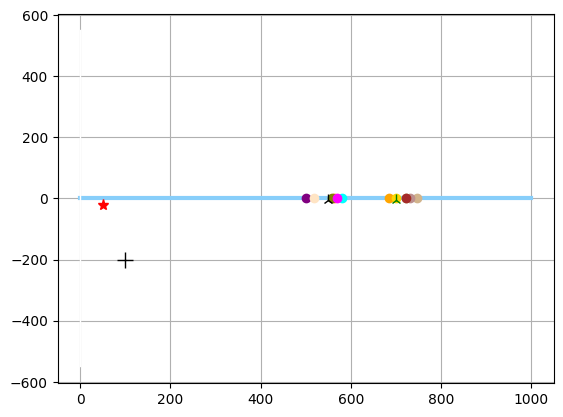

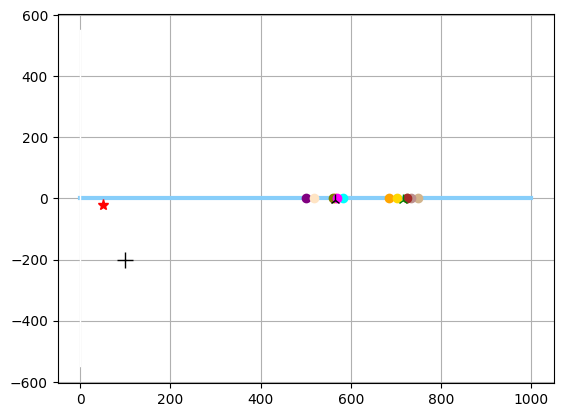

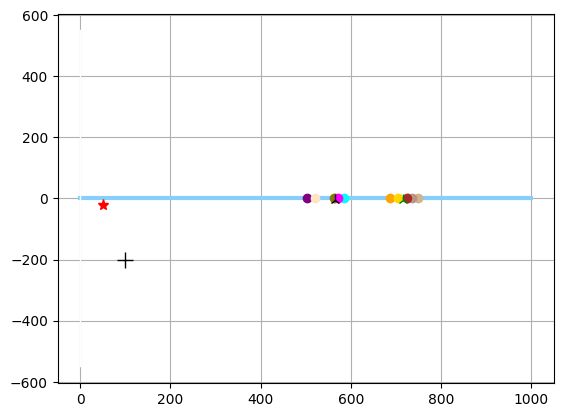

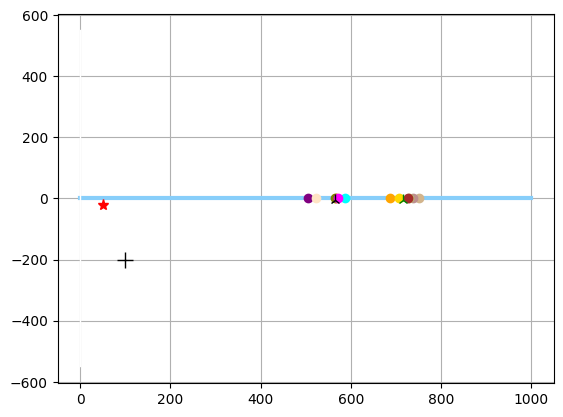

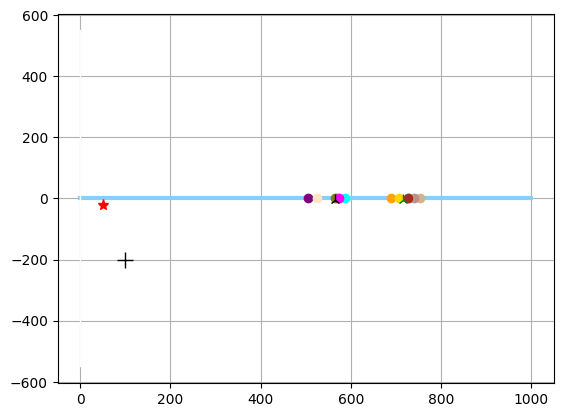

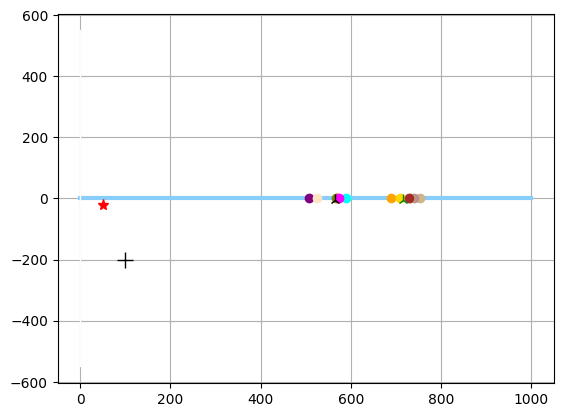

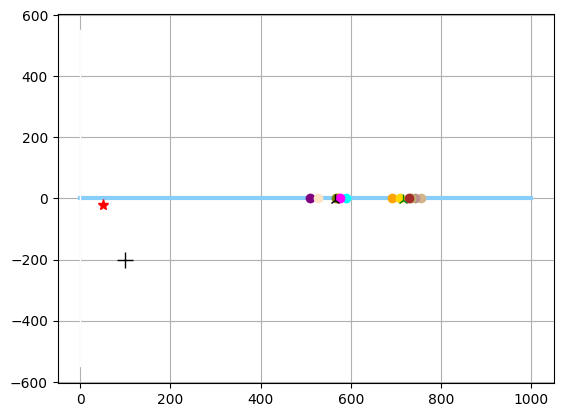

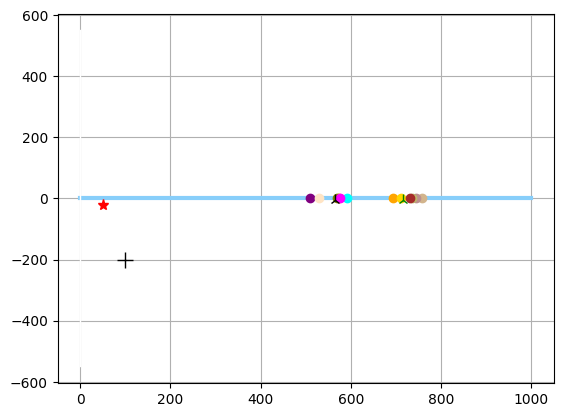

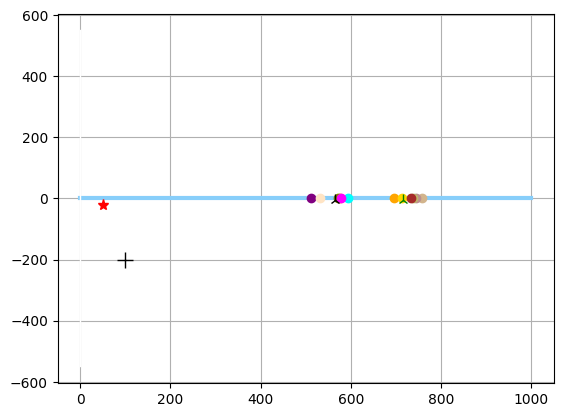

In [5]:
env = Env()

for r in range(200):
    env.greedyDo()

for step in env.location:

  xpoint=[]
  ypoint=[]
  col=["darkorange","cyan","purple","olive","magenta","bisque","tan","orange","gold","rosybrown","darkkhaki","brown"]
  plt.plot([1000, 0], [0, 0], color="lightskyblue", lw=3, linestyle='solid', label="_not in legend")
  plt.plot([0, 0], [550, -550], color="w", lw=1, linestyle='solid', label="_not in legend")

  # print(step)
  p=0
  for i in range(12):
      plt.plot(step[p], step[p+1], linestyle='none',color=col[i], marker='o')
      p=p+3
  # print(step[p],step[p+1],step[p+2])
  plt.plot(step[p], step[p+1], linestyle='none',color='green' ,ms = 8, marker='2')
  p=p+3
  plt.plot(step[p], step[p+1], linestyle='none',color='black' ,ms = 8, marker='2')

  plt.plot(env.w_RSU[0], env.w_RSU[1], linestyle='none',color='red',ms = 8, marker='*')
  plt.plot(100, -200, linestyle='none',color='black',ms = 12, marker='+')
  plt.grid()

  plt.show()

In [ ]:
from stable_baselines3 import PPO

env = Env()
# policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=dict(pi=[256,256,256,256], vf=[256,256,256,256])),policy_kwargs=policy_kwargs
model = PPO("MlpPolicy", env, verbose=1,n_steps=500)
model.learn(total_timesteps=100000,reset_num_timesteps=500)
model.save("myModel")
del model



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 500`, after every 7 untruncated mini-batches, there will be a truncated mini-batch of size 52
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=500 and n_envs=1)
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 642 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 500 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 539          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 1000         |
| train/                  |              |
|    approx_kl            | 0.0001850359 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.77        |
|    explained_variance   | -1.06e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.54e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0017      |
|    value_loss

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ypoints = np.array(env.rewards)

plt.plot(ypoints)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time: 1.0094896558404838 0.8295026998031906
Time: 1.0087119082035276 0.8284446860508561
Time: 1.0094896558404838 0.8295026998031906
Time: 1.0087119082035276 0.8284446860508561
Time: 1.0185908214672397 0.8434262753659142
Time: 1.0193524377052956 0.8444669500506735
Time: 1.0292101529305138 0.8595250931766084
Time: 1.0390641036870298 0.8746791286234852
Time: 1.0489155427239591 0.889931023968496
Time: 1.058765675836546 0.9052827162062188
Time: 1.0580616443719617 0.9043027043274997
Time: 1.0679245012623668 0.919769378901393
Time: 1.0674130731084333 0.9191209438376463
Time: 1.0772855114582904 0.9346987392028453
Time: 1.0674130731084333 0.9191209438376463
Time: 1.0772855114582904 0.9346987392028453
Time: 1.076960262544691 0.9343728456145227
Time: 1.0768123588528156 0.934361497696829
Time: 1.0768419427578761 0.9346646177027763
Time: 1.0669614102440323 0.9190890395048213
Time: 1.0768419427578761 0.9346646177027763
Time: 1.0063554171318574 0.8503176362123849
Time: 1.077048985767703 0.93528185247

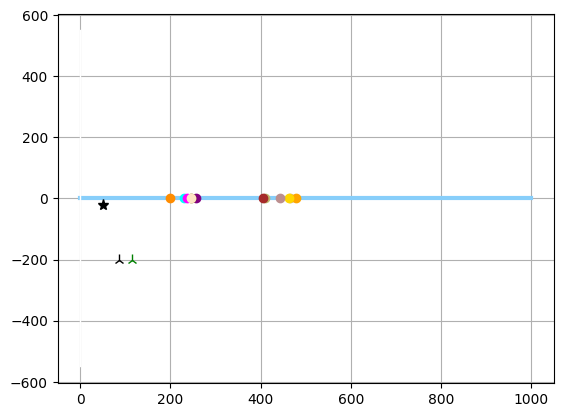

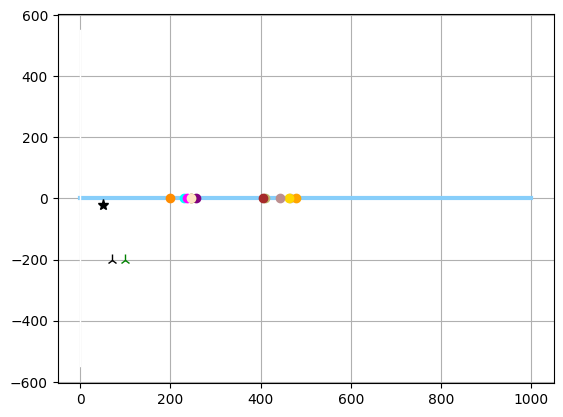

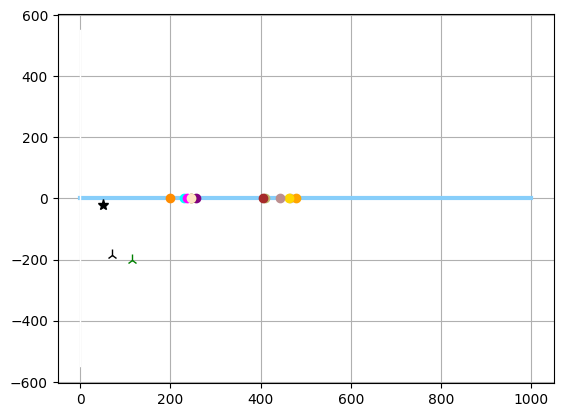

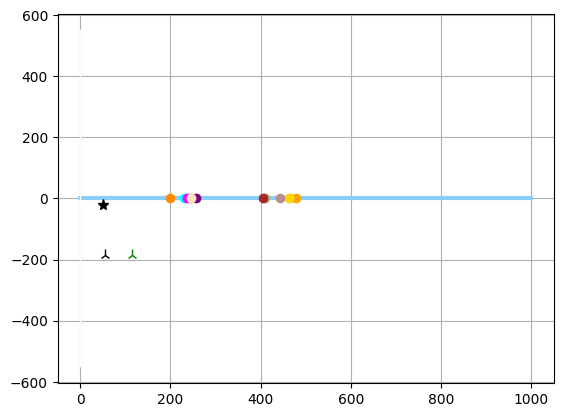

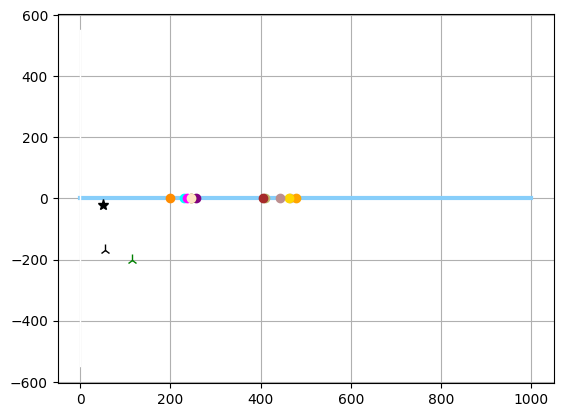

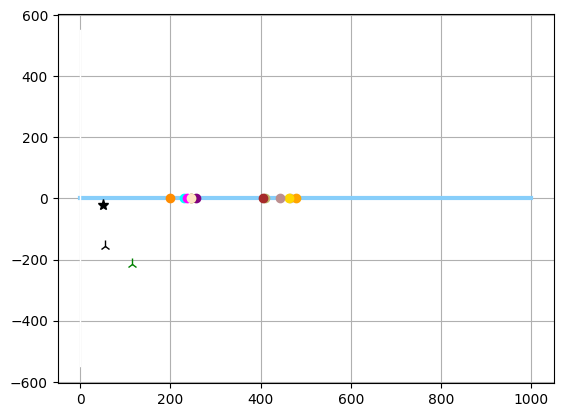

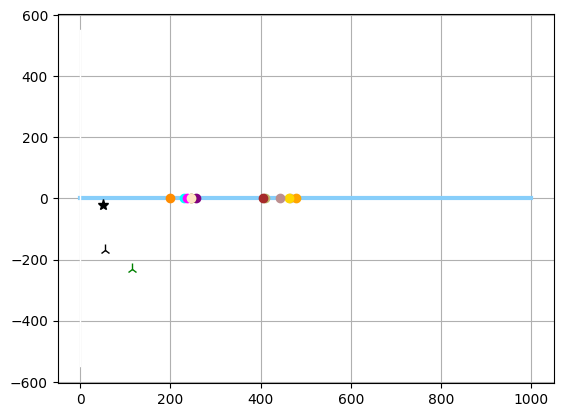

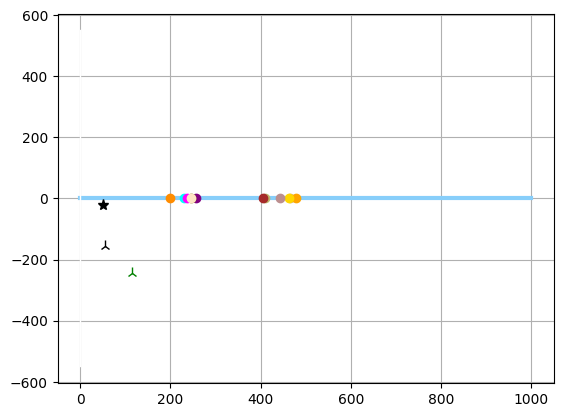

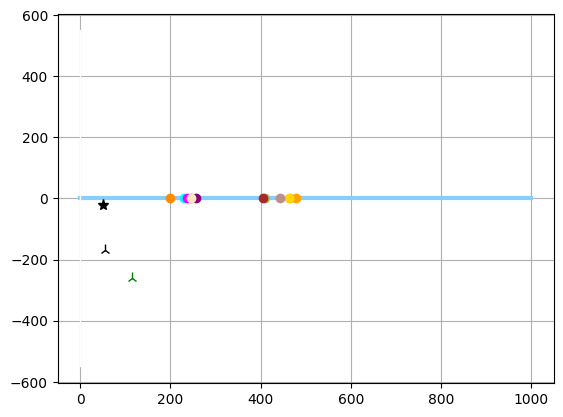

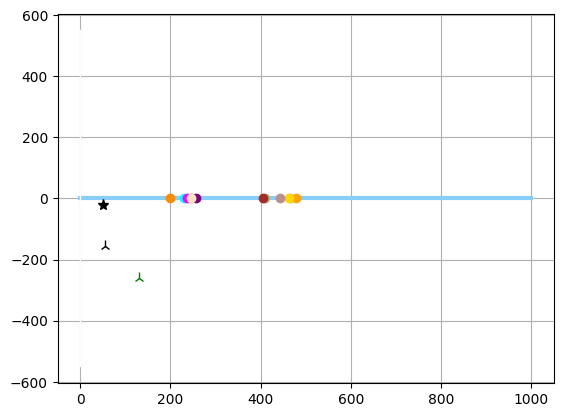

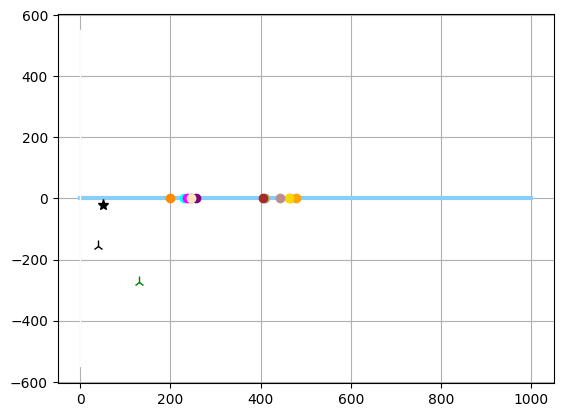

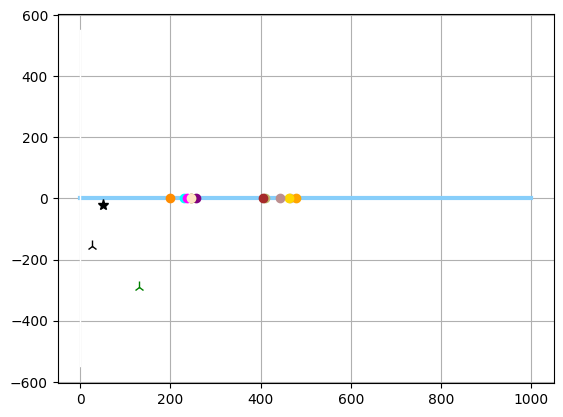

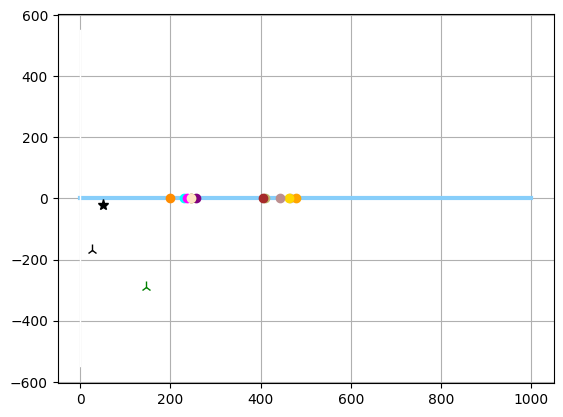

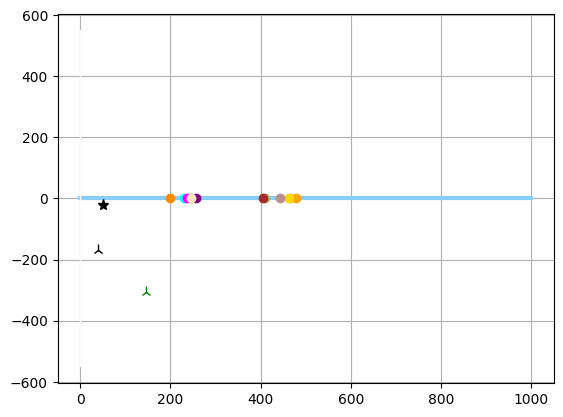

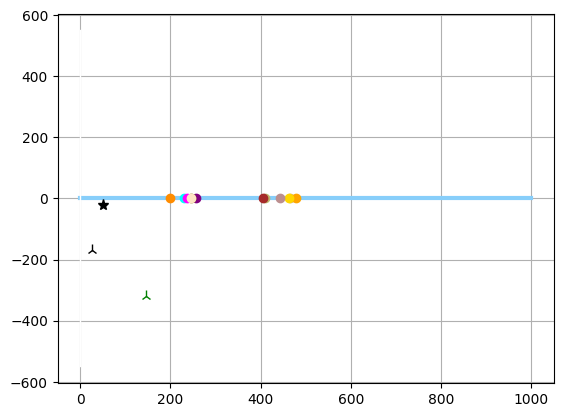

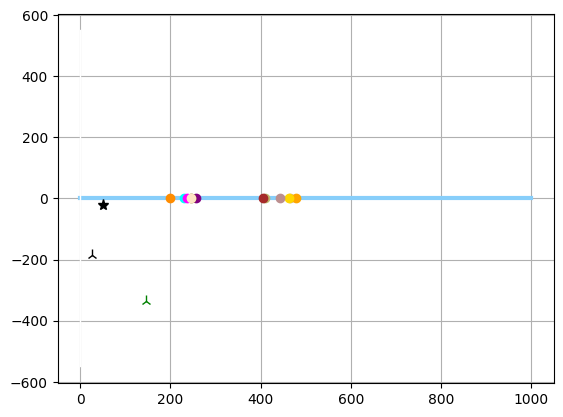

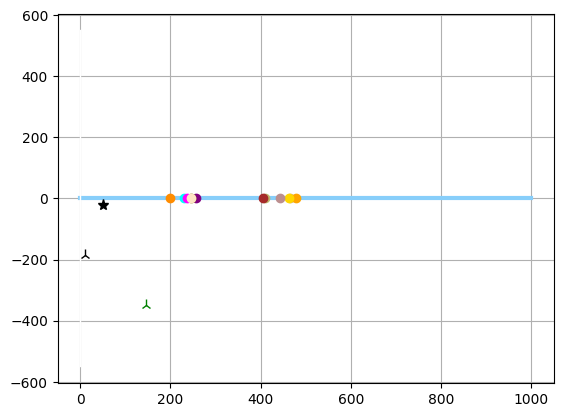

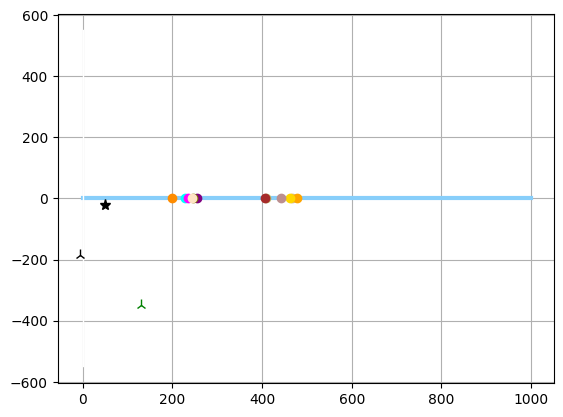

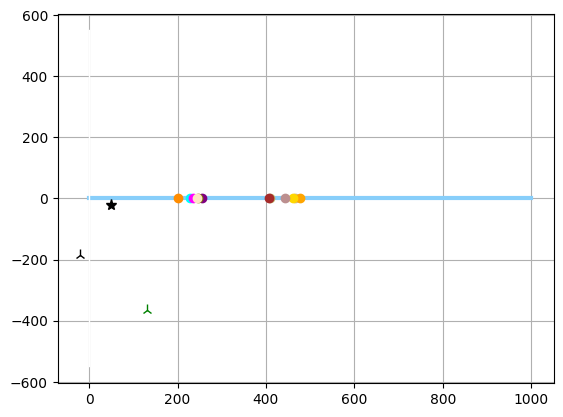

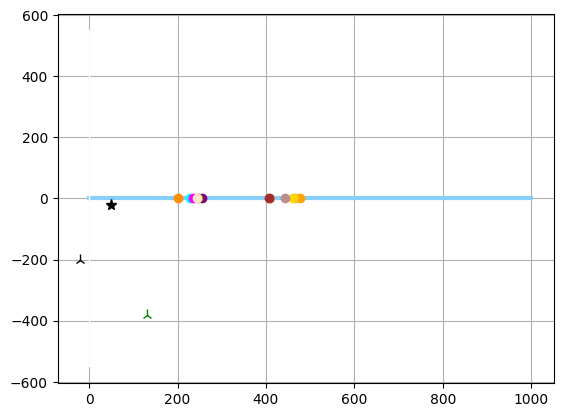

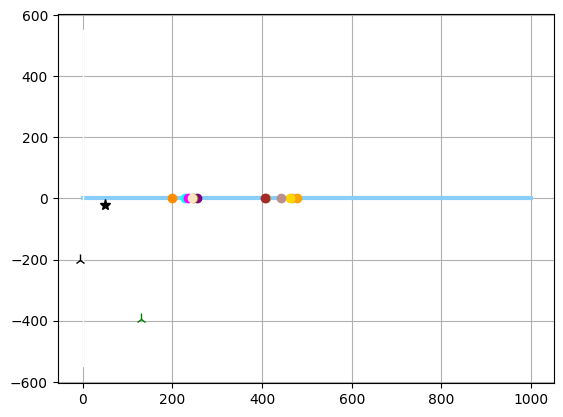

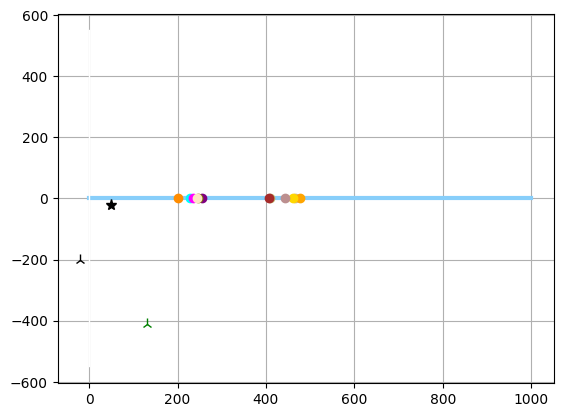

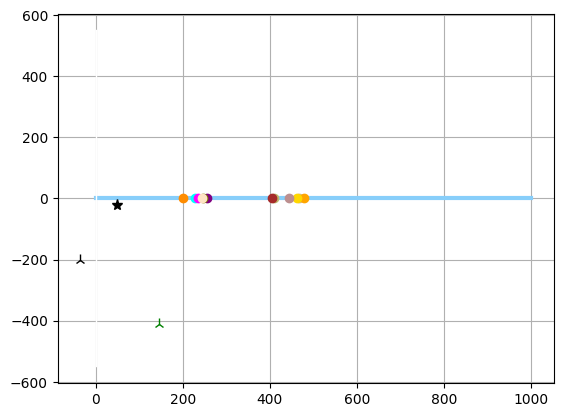

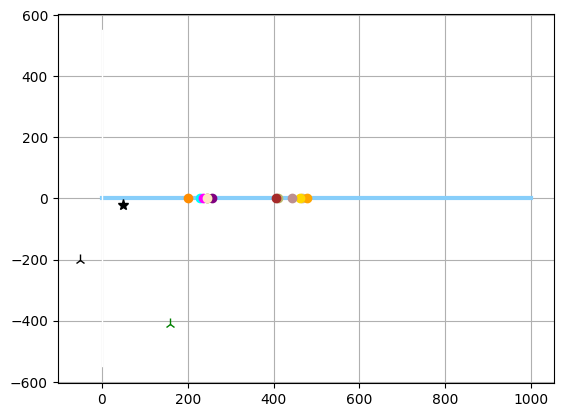

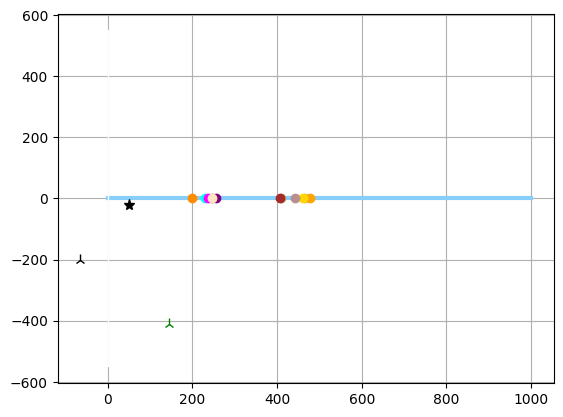

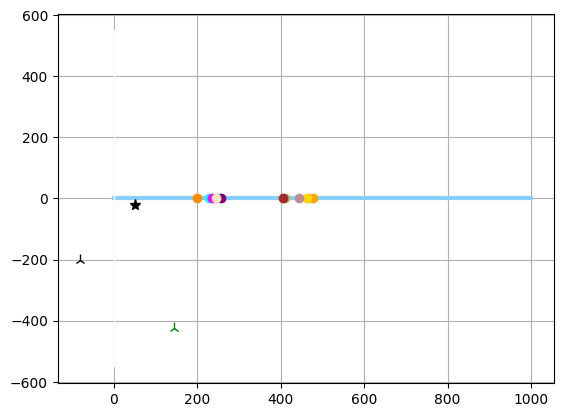

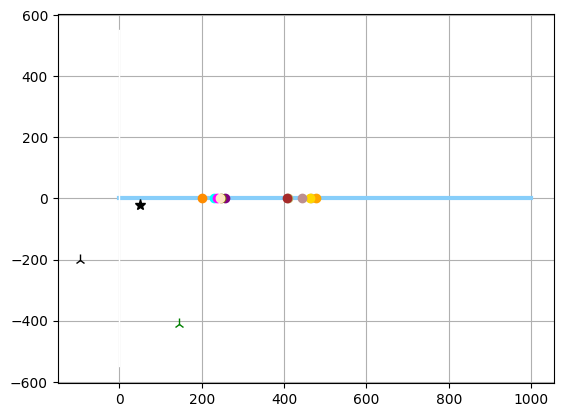

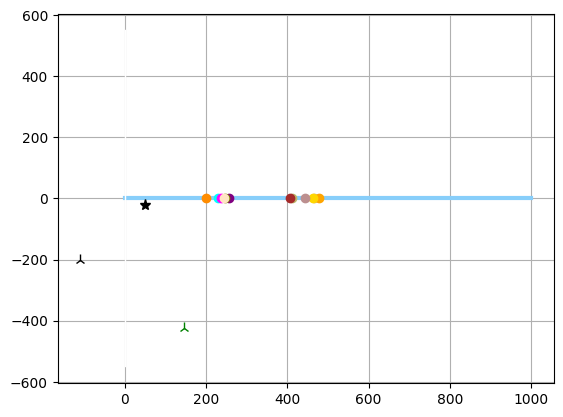

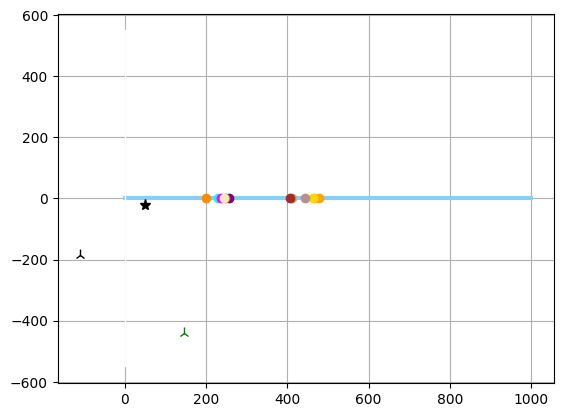

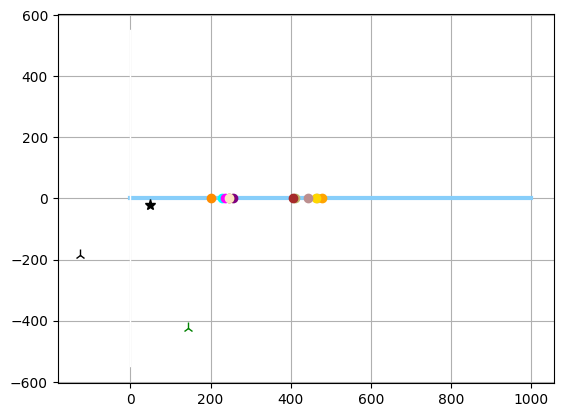

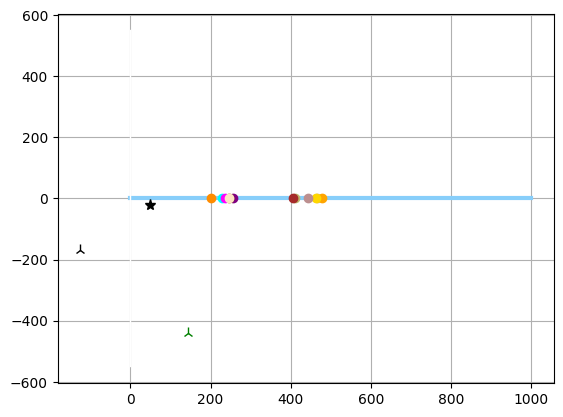

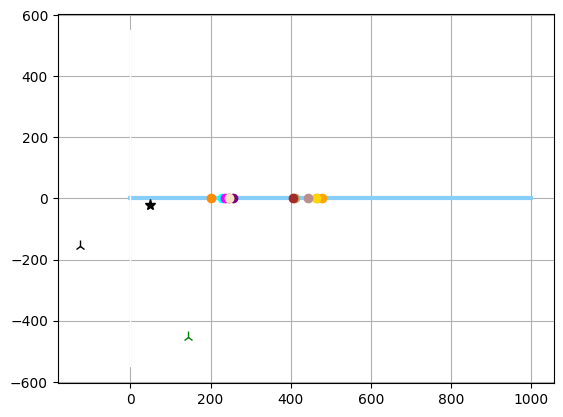

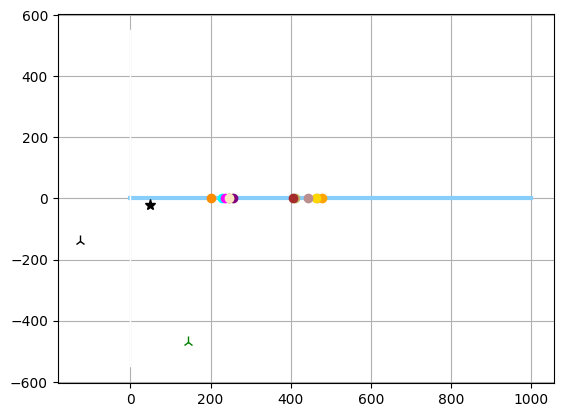

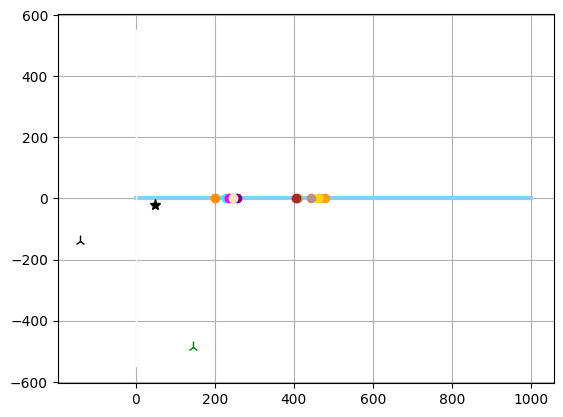

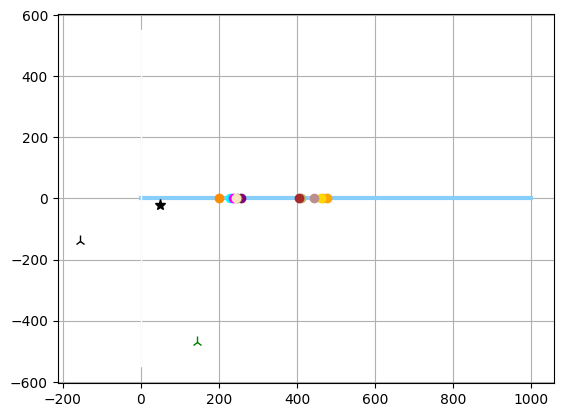

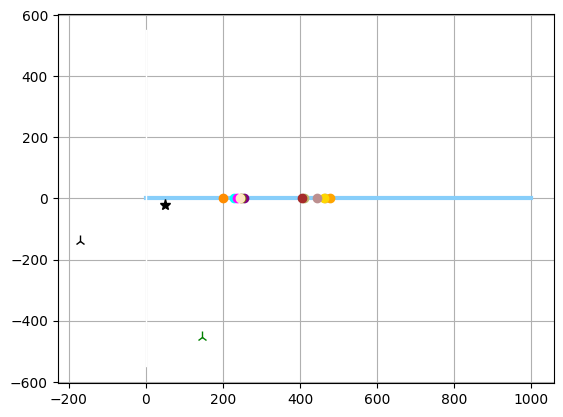

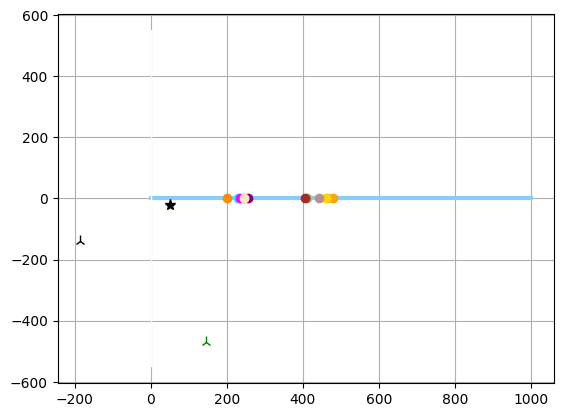

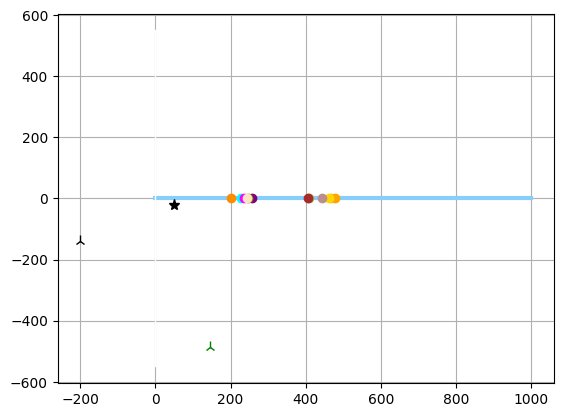

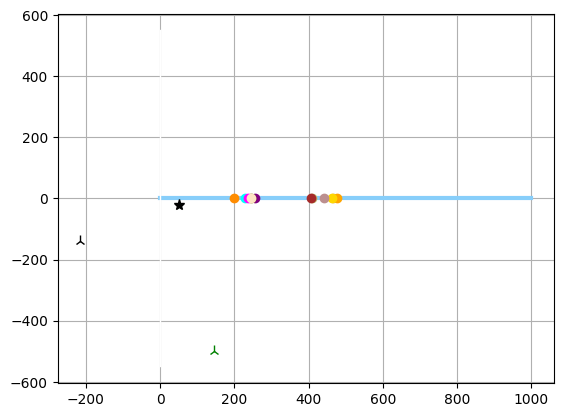

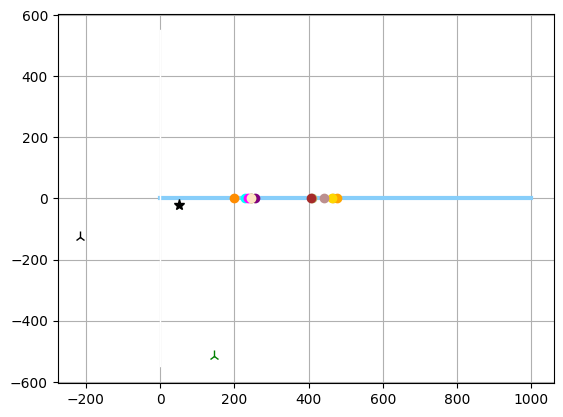

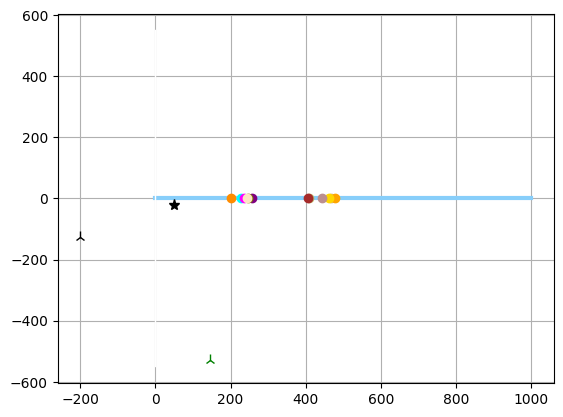

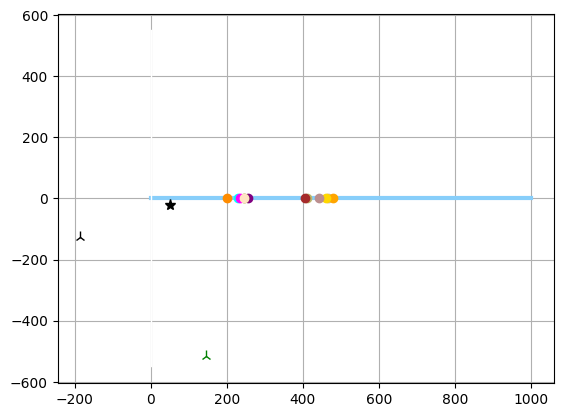

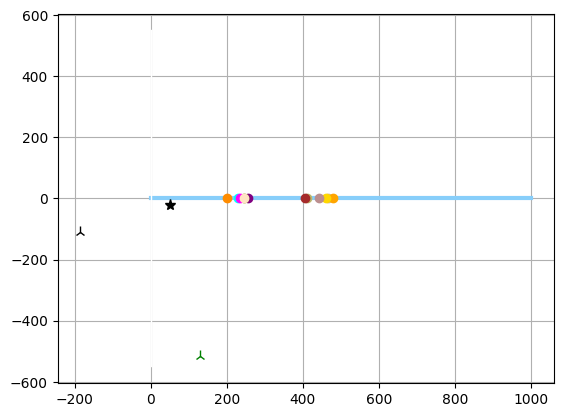

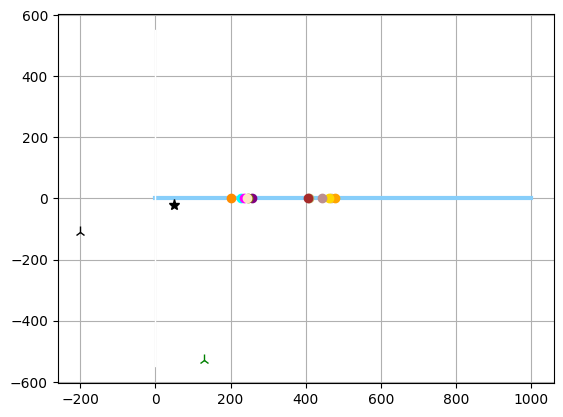

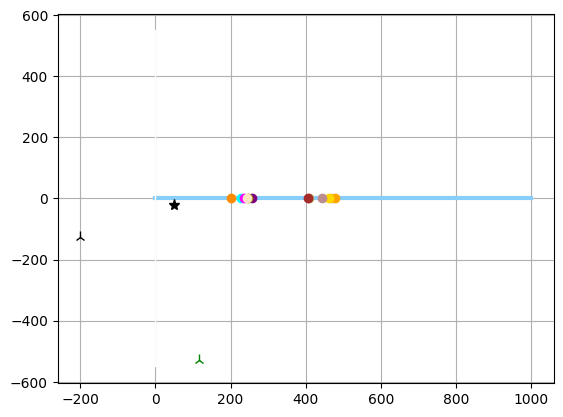

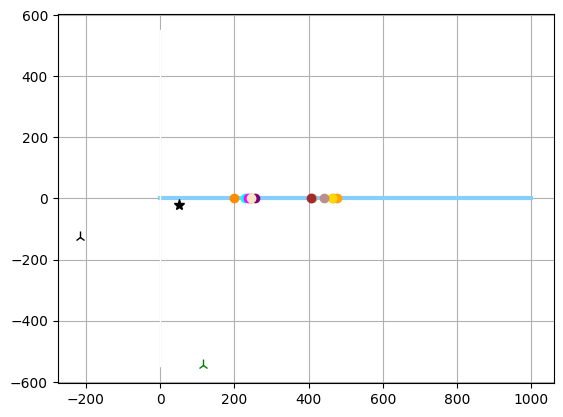

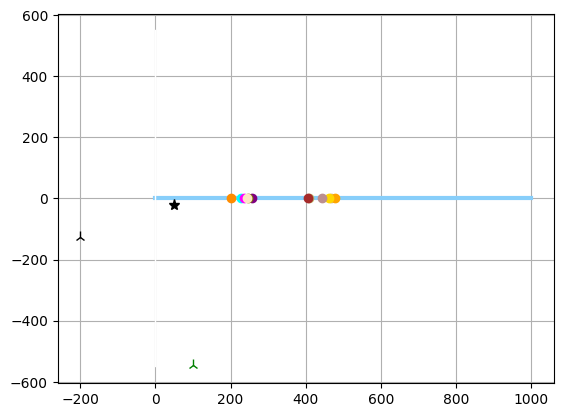

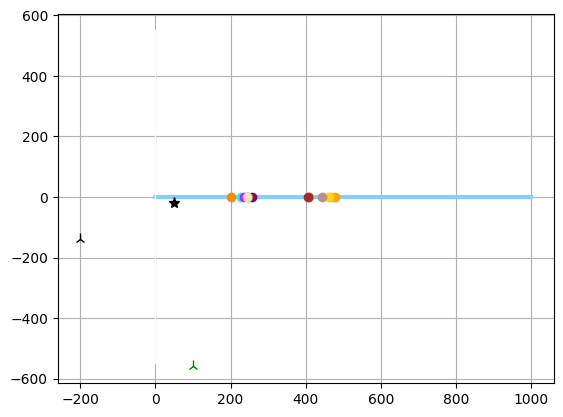

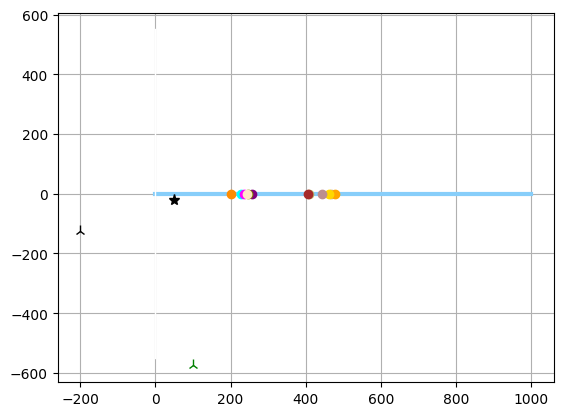

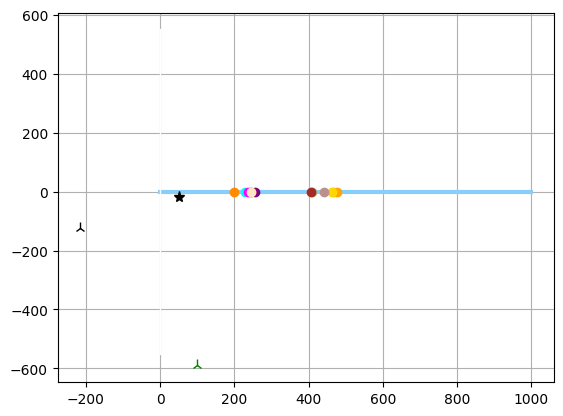

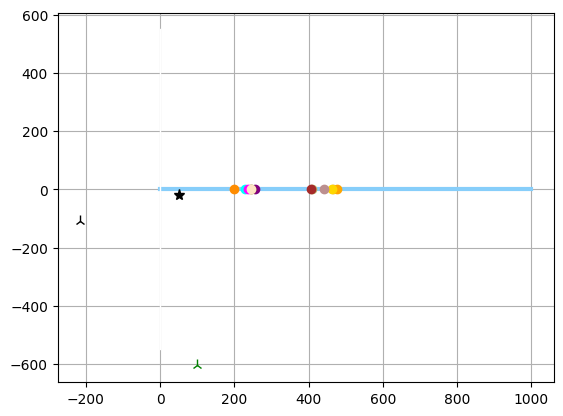

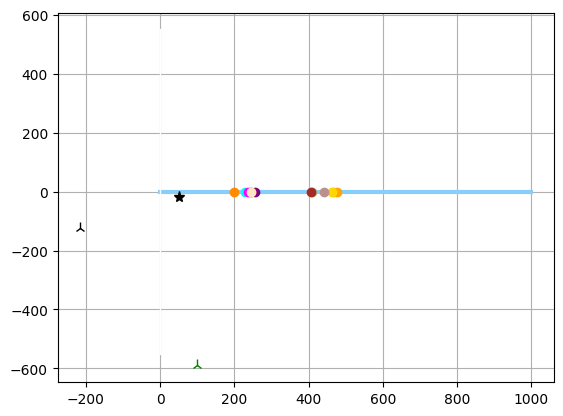

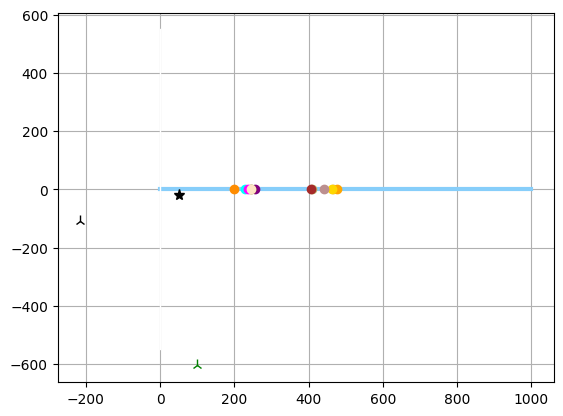

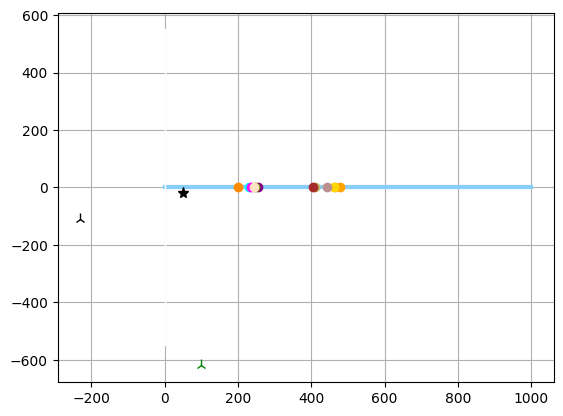

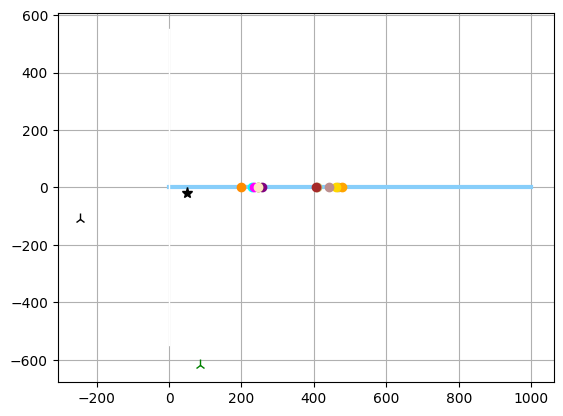

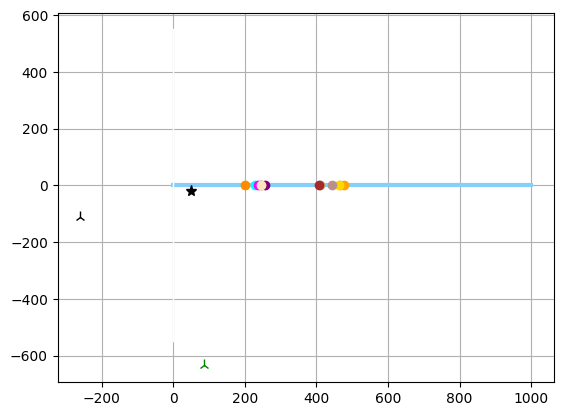

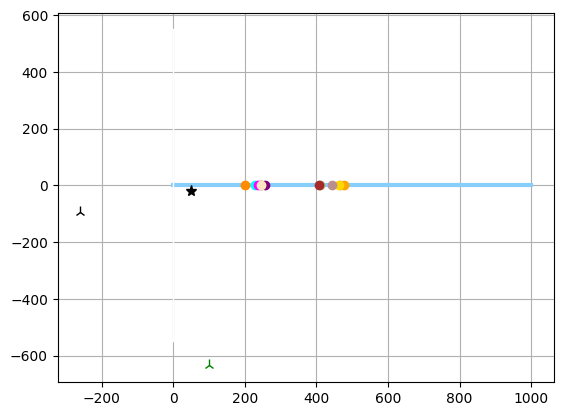

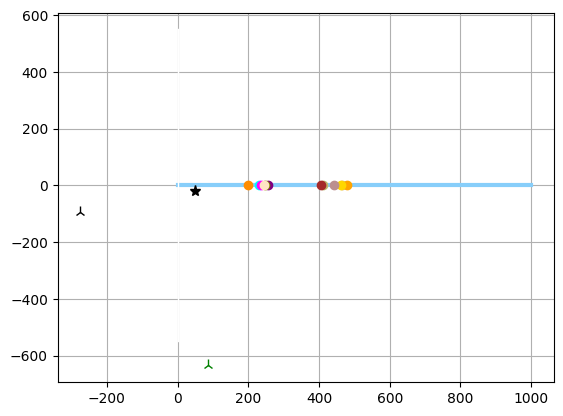

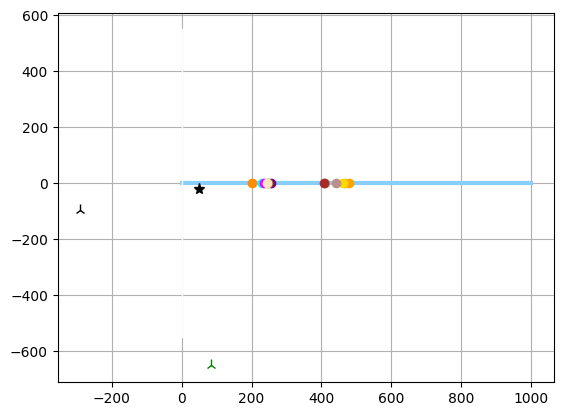

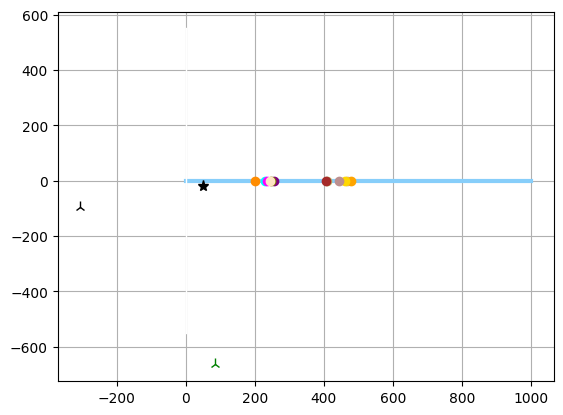

KeyboardInterrupt: 

In [18]:
env = Env()
model = PPO.load("myModel")
obs = env._get_obs()
env.location=[]
for i in range(250):
    action, _states = model.predict(obs)
    obs, rewards,terminated , truncated, info = env.step(action)


for step in env.location:

  xpoint=[]
  ypoint=[]
  col=["darkorange","cyan","purple","olive","magenta","bisque","tan","orange","gold","rosybrown","darkkhaki","brown"]
  plt.plot([1000, 0], [0, 0], color="lightskyblue", lw=3, linestyle='solid', label="_not in legend")
  plt.plot([0, 0], [550, -550], color="w", lw=1, linestyle='solid', label="_not in legend")

  # print(step)
  p=0
  for i in range(12):
      plt.plot(step[p], step[p+1], linestyle='none',color=col[i], marker='o')
      p=p+3
  # print(step[p],step[p+1],step[p+2])
  plt.plot(step[p], step[p+1], linestyle='none',color='green' ,ms = 8, marker='2')
  p=p+3
  plt.plot(step[p], step[p+1], linestyle='none',color='black' ,ms = 8, marker='2')

  plt.plot(env.w_RSU[0], env.w_RSU[1], linestyle='none',color='black',ms = 8, marker='*')
  plt.grid()

  plt.show()

